<a href="https://colab.research.google.com/github/yiftachsa/AI-Advanced/blob/main/image_contranstive_losses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optical Character Language Detection

In [2]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=99f4d637c70d72155bf4e2a9277a79e1628e44caff8776f078e7c56ce46fa107
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.config import list_physical_devices, list_logical_devices
from tensorflow.config.experimental import set_memory_growth
import GPUtil


In [4]:
gpus = list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      set_memory_growth(gpu, True)
    logical_gpus = list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    print(gpus)
  except RuntimeError as e:
    print(e)

print("GPU temperature", GPUtil.getGPUs()[0].temperature)

GPUtil.showUtilization(all=True)
GPUtil.showUtilization()

IndexError: list index out of range

##tensorflow_datasets


In [5]:
# tf.data.Dataset
(ds_train, ds_test), ds_info = tfds.load('omniglot', split=['train', 'test'], with_info=True)#, shuffle_files=True)

print(f"Train Dataset size: {ds_info.splits['train'].num_examples}")
print(f"Test Dataset size: {ds_info.splits['test'].num_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.10MNIR_3.0.0/omniglot-train.tfrecord*...:   0%|       …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.10MNIR_3.0.0/omniglot-test.tfrecord*...:   0%|        …

Generating small1 examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.10MNIR_3.0.0/omniglot-small1.tfrecord*...:   0%|      …

Generating small2 examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/omniglot/incomplete.10MNIR_3.0.0/omniglot-small2.tfrecord*...:   0%|      …

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.
Train Dataset size: 19280
Test Dataset size: 13180


In [6]:
# df = tfds.as_dataframe(ds)
# df = pd.DataFrame(df)

In [7]:
labels = np.arange(ds_info.features['label'].num_classes)
label_names = ds_info.features['label'].names
alphabet_names = ds_info.features['alphabet'].names

for example in ds_train.take(5):
    print(f"Image shape: {example['image'].shape}, Label: {example['label'].numpy()}, Label name: {label_names[example['label'].numpy()]}, 'char_id': {example['alphabet_char_id'].numpy()}, 'alphabet': {example['alphabet'].numpy()}, 'alphabet_name': {alphabet_names[example['alphabet'].numpy()]}")

Image shape: (105, 105, 3), Label: 617, Label name: Japanese_(katakana)_22, 'char_id': 22, 'alphabet': 27, 'alphabet_name': Japanese_(katakana)
Image shape: (105, 105, 3), Label: 672, Label name: Korean_30, 'char_id': 30, 'alphabet': 30, 'alphabet_name': Korean
Image shape: (105, 105, 3), Label: 325, Label name: Futurama_1, 'char_id': 1, 'alphabet': 17, 'alphabet_name': Futurama
Image shape: (105, 105, 3), Label: 672, Label name: Korean_30, 'char_id': 30, 'alphabet': 30, 'alphabet_name': Korean
Image shape: (105, 105, 3), Label: 177, Label name: Blackfoot_(Canadian_Aboriginal_Syllabics)_0, 'char_id': 0, 'alphabet': 12, 'alphabet_name': Blackfoot_(Canadian_Aboriginal_Syllabics)


In [8]:
labels = np.arange(ds_info.features['label'].num_classes)
label_names = ds_info.features['label'].names
alphabet_names = ds_info.features['alphabet'].names
alphabet_char_ids = []
for example in ds_train:
    alphabet_char_ids.append(int(example['alphabet_char_id'].numpy()))
print(set(alphabet_char_ids))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}


## Visualization


###tensorflow_dataset

In [9]:
def plot_sample(x, label_name):
  fig = plt.figure(figsize=(1,1))
  plt.imshow(x)
  plt.title(f"label: {label_name}")
  plt.axis('off')
  fig.show()

def get_sample_for_label(ds, label):
  filtered_ds = ds.filter(lambda data: tf.equal(data['label'], label))
  sampled_ds = filtered_ds.shuffle(1000).take(1)
  return next(iter(sampled_ds))

def plot_samples(ds, label_names):
  fig, axes = plt.subplots(2,5, figsize=(15,4))
  for i in range(2):
    for j in range(5):
      sample = next(iter(ds.shuffle(1000).take(1)))
      image = sample["image"]
      label = sample['label'].numpy()
      label_name= label_names[label]
      axes[i,j].imshow(image)
      axes[i,j].set_title(f"label: {label}: {label_name}")
      axes[i,j].axis('off')
  plt.tight_layout()
  plt.show()


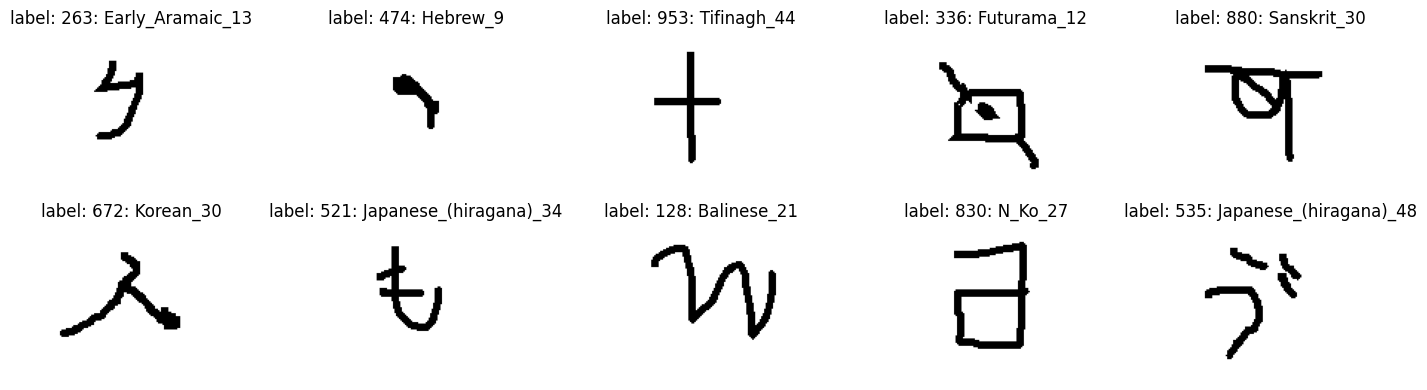

In [10]:
plot_samples(ds_train, label_names)

In [11]:
def filter_ds(ds, key, value):
  filtered_ds = ds.filter(lambda data: tf.equal(data[key], value))
  return filtered_ds

# filtered_dataset = filter_ds(ds_train, key='label', value=0)
# plot_samples(filtered_dataset, label_names)


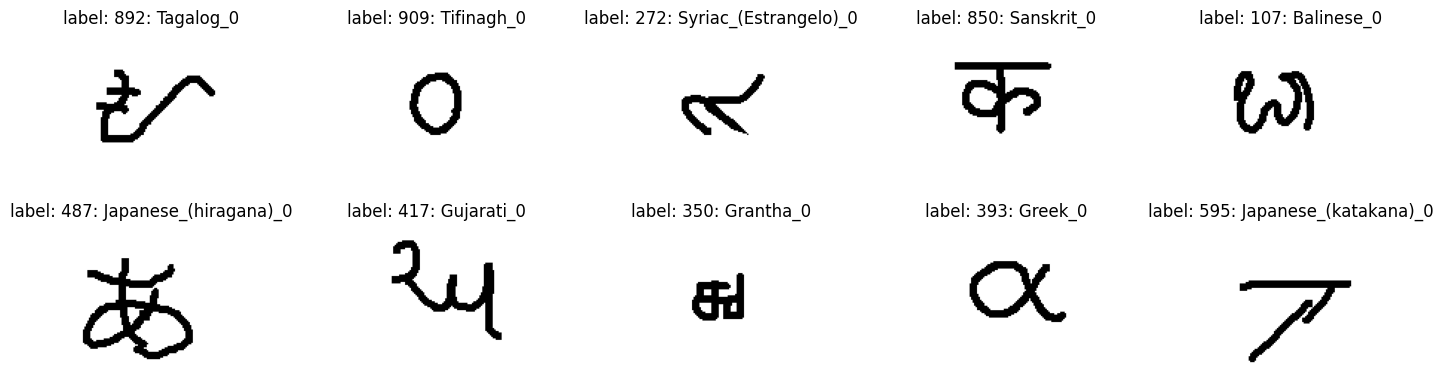

In [12]:
filtered_dataset = filter_ds(ds_train, key='alphabet_char_id', value=0)
plot_samples(filtered_dataset, label_names)


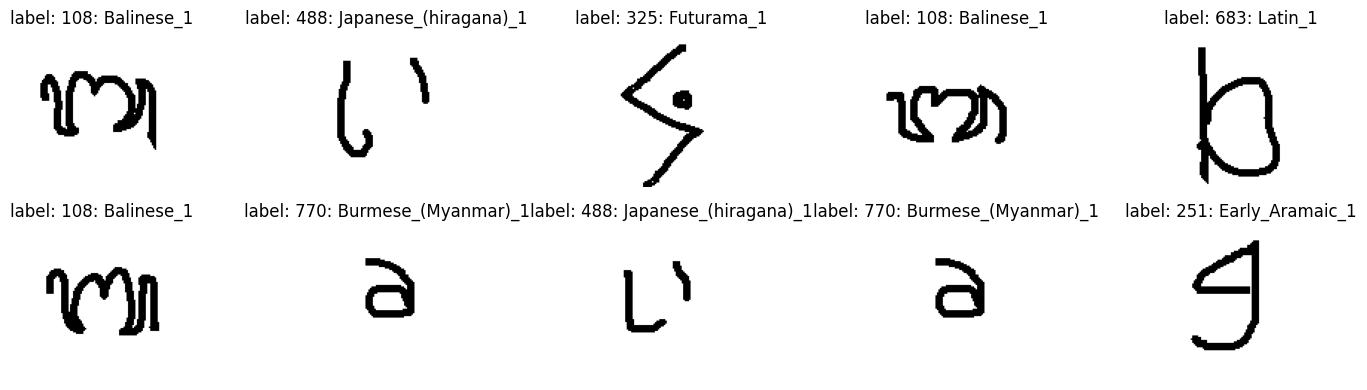

In [13]:
filtered_dataset = filter_ds(ds_train, key='alphabet_char_id', value=1)
plot_samples(filtered_dataset, label_names)


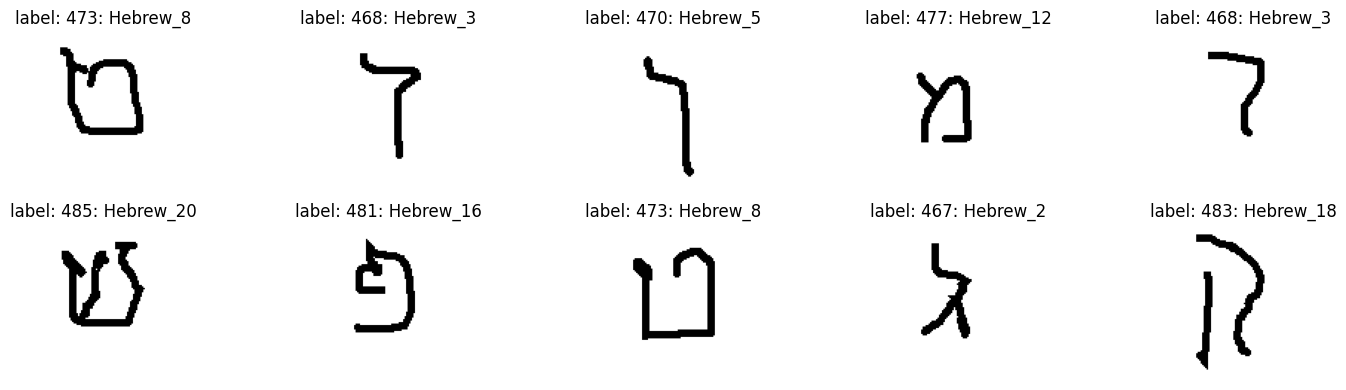

In [14]:
filtered_dataset = filter_ds(ds_train, key='alphabet', value=alphabet_names.index("Hebrew"))
plot_samples(filtered_dataset, label_names)

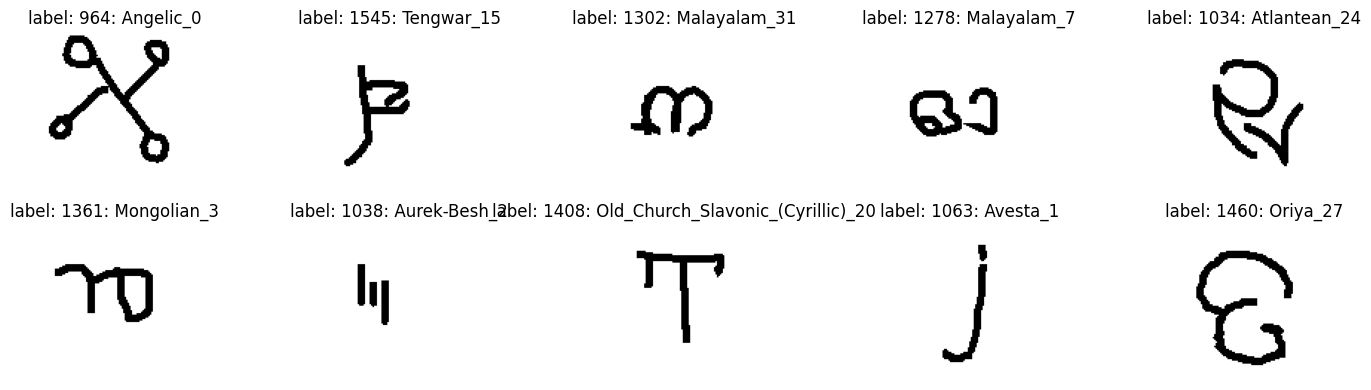

In [15]:
filtered_dataset = filter_ds(ds_test, key='alphabet', value=alphabet_names.index("Hebrew"))
plot_samples(ds_test, label_names)

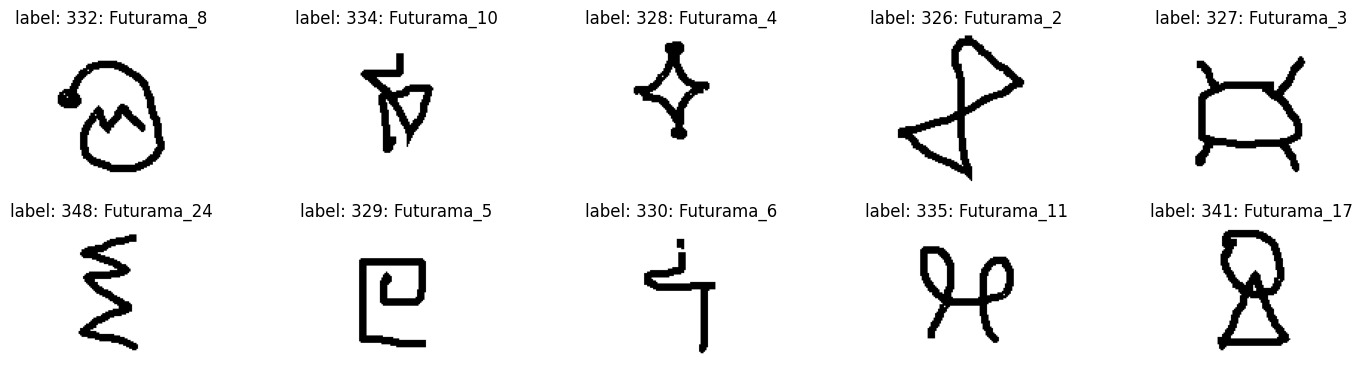

In [16]:
filtered_dataset = filter_ds(ds_train, key='alphabet', value=alphabet_names.index("Futurama"))
plot_samples(filtered_dataset, label_names)

##Preprocess


###Traget definition and EDA

ds_test is irrelevant for the task of classifing languages due to the mutual exclustion of the languages between train and test sets. We will disregard ds_test for now.

We will select 10 languages to try and diffrintiate between. Train/Test split is done from ds_train 70/30 ratio

In [17]:
unique_alphabets_train = set()
for example in ds_train:
    unique_alphabets_train.add(int(example['alphabet'].numpy()))

unique_alphabets_test = set()
for example in ds_test:
    unique_alphabets_test.add(int(example['alphabet'].numpy()))

print(f"unique_alphabets_train\n {unique_alphabets_train}")
print([alphabet_names[i] for i in unique_alphabets_train])
print(f"unique_alphabets_test\n {unique_alphabets_test}")
print([alphabet_names[i] for i in unique_alphabets_test])

print("intersection", unique_alphabets_train.intersection(unique_alphabets_test))
print("union", unique_alphabets_train.union(unique_alphabets_test))

unique_alphabets_train
 {0, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 30, 31, 32, 35, 37, 38, 41, 43, 45, 48}
['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
unique_alphabets_test
 {1, 6, 7, 8, 9, 18, 19, 23, 28, 29, 33, 34, 36, 39, 40, 42, 44, 46, 47, 49}
['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylhe

In [18]:
unique_alphabet_char_id_train = set()
for example in ds_train:
    unique_alphabet_char_id_train.add(int(example['alphabet_char_id'].numpy()))

unique_alphabet_char_id_test = set()
for example in ds_test:
    unique_alphabet_char_id_test.add(int(example['alphabet_char_id'].numpy()))

print(unique_alphabet_char_id_train)
print(unique_alphabet_char_id_test)

print("intersection", unique_alphabet_char_id_train.intersection(unique_alphabet_char_id_test))
print("union", unique_alphabet_char_id_train.union(unique_alphabet_char_id_test))
print("only in train", unique_alphabet_char_id_train- unique_alphabet_char_id_test)
print("only in test", unique_alphabet_char_id_test- unique_alphabet_char_id_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
intersection {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
union {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}
only in train {47, 48, 49, 50, 51, 52, 53, 54}
only in test set()


In [19]:
def filter_ds_multiple(ds, key, values):
  filtered_ds = ds.filter(lambda data: tf.reduce_any([tf.equal(data[key], value) for value in values]))
  return filtered_ds

def count_samples(ds):
  count = 0
  cardinality = ds.cardinality().numpy()
  if cardinality == tf.data.experimental.UNKNOWN_CARDINALITY:
      # print("cardinality unknown, count manually")
      count = len(list(ds))
  else:
      count = cardinality
  return count

def count_labels(ds, field='alphabet'):
  label_counts = {}
  for example in ds:
    value = int(example[field].numpy())
    label_counts[value] = label_counts.get(value, 0) + 1
  return label_counts

def split_dataset(ds, test_ratio=0.3, seed=42):
  ds_train = ds.shuffle(buffer_size=10000, seed=seed) # Shuffle before splitting
  ds_size = count_samples(ds)
  test_size = int(test_ratio * ds_size)
  ds_train_split = ds.take(ds_size-test_size)
  ds_test_split = ds.skip(ds_size-test_size)
  return ds_train_split, ds_test_split




In [20]:
alphabet_names_in_train = np.array(alphabet_names)[list(unique_alphabets_train)]
selected_alphabets_names = alphabet_names_in_train[8:18]
selected_alphabets = [alphabet_names.index(name) for name in selected_alphabets_names]
ds_filtered = filter_ds_multiple(ds_train, key='alphabet', values=selected_alphabets)

# plot_samples(filtered_dataset, label_names)
print("ds_train samples", count_samples(ds_train))
print("filtered_dataset samples", count_samples(ds_filtered))

selected_alphabets_tensor = tf.constant(selected_alphabets, dtype=tf.int64)

def remap_alphabet(x):
  equal = tf.equal(x['alphabet'], selected_alphabets_tensor)
  new_label = tf.argmax(tf.cast(equal, tf.int32), axis=0)
  return {**x, 'alphabet': new_label}

ds_filtered = ds_filtered.map(remap_alphabet)

ds_train samples 19280
filtered_dataset samples 5880


In [21]:
target_label = "alphabet_one_hot"
num_classes = len(selected_alphabets)
input_shape = ds_filtered.element_spec['image'].shape
#Split
ds_train_split, ds_test_split = split_dataset(ds_filtered)

print(f"ds_filtered size: {count_samples(ds_filtered)}")
print(f"Train Split size: {count_samples(ds_train_split)}")
print(f"Test Split size: {count_samples(ds_test_split)}")

train_label_counts = count_labels(ds_train_split)
test_label_counts = count_labels(ds_test_split)

print("Train Label Counts:", train_label_counts)
print("Test Label Counts:", test_label_counts)

# replacing "label" with one hot alphabet
ds_train_split = ds_train_split.map(lambda x: {**x, 'alphabet_one_hot': tf.one_hot(x['alphabet'], depth=num_classes)})
ds_test_split = ds_test_split.map(lambda x: {**x, 'alphabet_one_hot': tf.one_hot(x['alphabet'], depth=num_classes)})


ds_filtered size: 5880
Train Split size: 4116
Test Split size: 1764
Train Label Counts: {4: 361, 2: 450, 6: 340, 9: 222, 0: 368, 1: 485, 5: 597, 3: 317, 8: 309, 7: 667}
Test Label Counts: {9: 98, 1: 195, 4: 159, 6: 140, 5: 263, 2: 210, 3: 123, 7: 293, 8: 131, 0: 152}


In [22]:
import pandas as pd
df_counts = pd.DataFrame({'train': train_label_counts, 'test': test_label_counts})
df_counts = df_counts.rename(index=lambda x: selected_alphabets_names[x])
df_counts.loc['Total'] = df_counts.sum(axis=0)
df_counts["Total"] = df_counts.sum(axis=1)
df_counts

train  test  Total
Futurama                                     361   159    520
Cyrillic                                     450   210    660
Greek                                        340   140    480
Inuktitut_(Canadian_Aboriginal_Syllabics)    222    98    320
Braille                                      368   152    520
Burmese_(Myanmar)                            485   195    680
Grantha                                      597   263    860
Early_Aramaic                                317   123    440
Hebrew                                       309   131    440
Gujarati                                     667   293    960
Total                                       4116  1764   5880

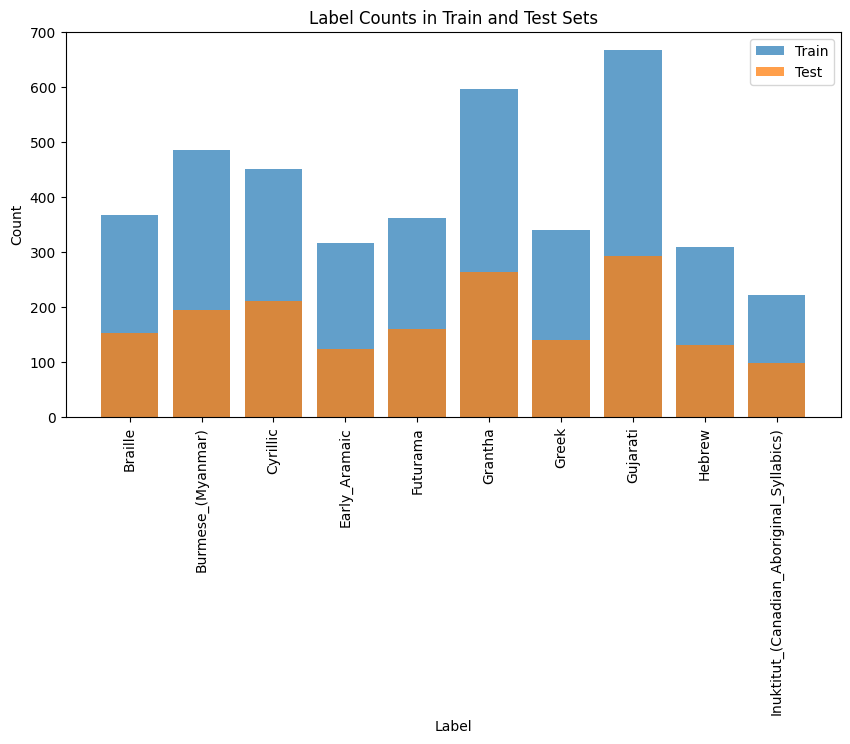

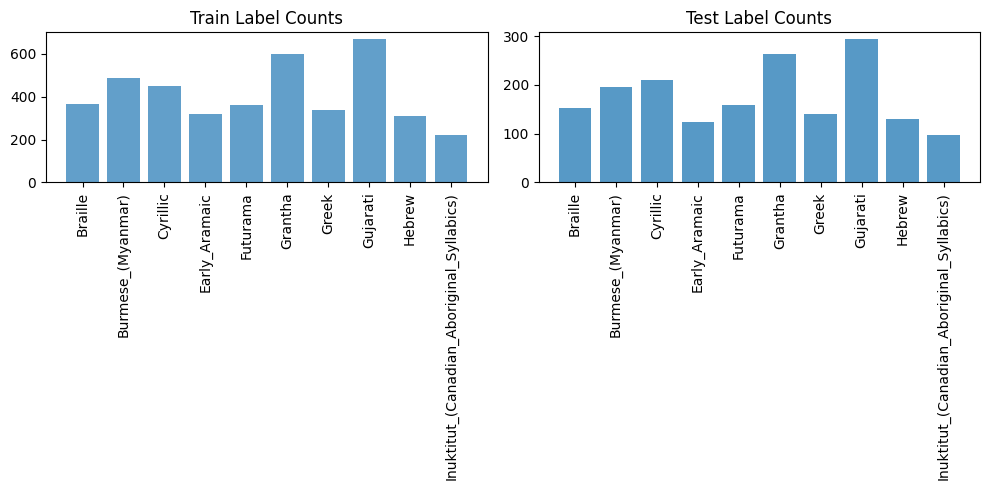

In [23]:
 fig = plt.figure(figsize=(10,5))
plt.bar(train_label_counts.keys(), train_label_counts.values(), label='Train', alpha=0.7)
plt.bar(test_label_counts.keys(), test_label_counts.values(), label='Test', alpha=0.75)
plt.xticks(list(train_label_counts.keys()), [selected_alphabets_names[i] for i in train_label_counts.keys()], rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts in Train and Test Sets')
plt.legend()
plt.show()


fig,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].bar(train_label_counts.keys(), train_label_counts.values(), label='Train', alpha=0.7)
ax[0].set_title("Train Label Counts")
ax[0].set_xticks(list(train_label_counts.keys()))
ax[0].set_xticklabels([selected_alphabets_names[i] for i in train_label_counts.keys()], rotation=90)

ax[1].bar(test_label_counts.keys(), test_label_counts.values(), label='Test', alpha=0.75)
ax[1].set_title("Test Label Counts")
ax[1].set_xticks(list(test_label_counts.keys()))
ax[1].set_xticklabels([selected_alphabets_names[i] for i in test_label_counts.keys()], rotation=90)
plt.tight_layout()
plt.show()



###Augment

In [24]:
def get_preprocessing_pipeline(resize_shape=None, is_training=True):
    layers = []

    if resize_shape:
        h, w = resize_shape
        layers.append(tf.keras.layers.Resizing(h, w))

    layers.append(tf.keras.layers.Rescaling(1./255))

    if is_training:
        layers.extend([
            tf.keras.layers.RandomRotation(0.05),
            # # tf.keras.layers.RandomZoom(0.1),
            # tf.keras.layers.RandomContrast(0.1),
            tf.keras.layers.RandomTranslation(0.1, 0.1),
        ])

    return tf.keras.Sequential(layers)

In [25]:
# train_data_aug = get_preprocessing_pipeline(is_training=True)
# test_data_aug = get_preprocessing_pipeline(is_training=False)

# ds_train_aug = ds_train.map(lambda x: {**x, 'image': train_data_aug(x['image'])})
# ds_test_aug = ds_test.map(lambda x: {**x, 'image': test_data_aug(x['image'])})

# sample = next(iter(ds_train_aug))
# plot_sample(sample['image'].numpy(), sample['alphabet'].numpy())


#Losses

##compactness loss
Compacness loss that aims to decrease the variance within a class.

$V[x] = \frac{1}{(n-1)k}\Sigma_j^k\Sigma_i^n(x-x̅)^2$ , $x̅ = \frac{\Sigma_i^n x_i}{n}$

**Feature-wise Variance**

$V_f[x] = \frac{\Sigma_i^n(x-x̅)^2}{n-1}$ , $x̅ = \frac{\Sigma_i^n x_i}{n}$

**Mean Variance** (Mean instead of sum to regulate based on length)

$V[x] = \frac{\Sigma_j^kV_f[x]}{k}$


Calculation insights:
 - **Vectorization** of iteration over labels using **map**
 - Per feature variance:
  - Mean embedding vector
  - Sum Squered diffrences
  - Mean Sum Squered diffrences per feature (Variance)
 - Mean of featurewise variance


In [26]:
class CompactnessLossMap(tf.keras.losses.Loss):
  def __init__(self, name='compactness_loss', pop_var=False, ss_axis=0):
      super().__init__(name=name)
      self.pop_var = pop_var
      self.ss_axis = ss_axis

  def _variance(self, x):
    mean = tf.reduce_mean(x, axis=0) #[embed_dim,] # average across samples - mean vector
    if self.pop_var:
      freedom_deg = tf.shape(x)[self.ss_axis]
    else: #sample var
      freedom_deg = tf.shape(x)[self.ss_axis] - 1
    freedom_deg = tf.cast(freedom_deg, tf.float32)

    square_diff = tf.square(tf.subtract(x, mean)) #[n, embed_dim]
    sum_square_diff = tf.reduce_sum(square_diff, axis=self.ss_axis) #[embed_dim, ]
    var_featurewise = tf.divide(sum_square_diff, freedom_deg) #var per feature #[embed_dim, ]
    return tf.reduce_mean(var_featurewise)

  def _label_variance(self, label, labels, y_pred):
    label_mask = tf.equal(labels, label) #[batch_size,]
    label_samples = tf.boolean_mask(y_pred, label_mask) #[num_samples_with_label, embedding_dim]
    res = tf.cond(tf.less(tf.shape(label_samples)[0], 2), lambda: tf.constant(0.0, dtype=tf.float32),  # If freedom_deg is 0, return 0.0
                  lambda: tf.reduce_mean(self._variance(label_samples)))
    return res

  def call(self, y_true, y_pred):
    """
    Recieves the labels and the embeddings of the samples and
    reduces the variance within classes (between samples of the same label)

    key points:
      - batch size is recommended to be large enough to include at least 2 samples per label
      - variance of a single sample is 0, therefor no penelty is applied

    Args:
    y_true: [batch_size, num_classes]
    y_pred: [batch_size, embedding_dim] #embeddings
    """
    labels = tf.argmax(y_true, axis=1) #[batch_size,]
    unique_labels = tf.unique(labels)[0] #[num_classes,]

    labels_variances = tf.map_fn(
            lambda label: self._label_variance(label, labels, y_pred),
            unique_labels,
            dtype=tf.float32
        )
    return tf.reduce_mean(labels_variances)

class CompactnessLossVectorized(tf.keras.losses.Loss):
  def __init__(self, name='compactness_loss', pop_var=False):
    super().__init__(name=name)
    self.pop_var = pop_var

  def filter_by_count(self, y_true, y_pred, min_val=2):
    labels = tf.cast(tf.argmax(y_true, axis=1), tf.int32)  # (N,)
    _, _, counts = tf.unique_with_counts(labels)

    #keep only samples that belong to classes with more than a single sample in a batch
    valid_mask = tf.squeeze(counts >= min_val)  # (n_classes,)
    valid_label_indices = tf.cast(tf.where(valid_mask)[:, 0], tf.int32)
    is_valid_sample = tf.reduce_any(
        tf.equal(tf.expand_dims(labels, 1), tf.expand_dims(valid_label_indices, 0)), axis=1
    )
    y_true_filter = tf.boolean_mask(y_true, is_valid_sample)
    y_pred_filter = tf.boolean_mask(y_pred, is_valid_sample)
    return y_true_filter, y_pred_filter


  def call(self, y_true, y_pred):
    #keep only samples that belong to classes with more than a single sample in a batch
    y_true_filter, y_pred_filter = self.filter_by_count(y_true, y_pred)

    labels = tf.cast(tf.argmax(y_true_filter, axis=1), tf.int32)  # (N,)
    N = tf.shape(y_pred_filter)[0]
    n_feat = tf.shape(y_pred_filter)[1]


    # compute per-label mean embeddings
    _, _, counts = tf.unique_with_counts(labels)
    num_classes = tf.reduce_max(labels) + 1
    counts = tf.cast(tf.expand_dims(counts, -1), tf.float32) # (num_classes, 1)

    # for each label i - calculate the mean feature vector
    ## option 1:
    # sum_per_label = tf.math.unsorted_segment_sum(embeds, labels, num_classes)  # (num_classes, n_feat)
    # # Not neccessary - Tensorflow broadcasting is implicit
    # # count_per_label = tf.repeat(counts, repeats=D, axis=1) #  (num_classes, 1) --> (num_classes, n_feat)
    # mean_per_label = tf.divide(sum_per_label, counts)  # (num_classes, n_feat)

    ## option 2
    mean_per_label = tf.math.unsorted_segment_mean(y_pred_filter, labels, num_classes) # (num_classes, n_feat)
    #(N,n_feat), (N,), num_samples --> (num_classes, n_feat)

    # for each sample, calculate the squared difference.
    # first gather the relevant mean per sample - Should be (N,n_feat)
    mean_per_sample = tf.gather(mean_per_label, labels) # (n_classes, n_feat), (N,) --> (N, n_feat)
    # calc squered diffs
    diff_per_sample = tf.subtract(y_pred_filter, mean_per_sample) #(N, n_feat)
    square_diff_per_sample = tf.square(diff_per_sample) #(N, n_feat)

    # calc sum squered diff per class (using the same method as before)
    sum_squered_diff_per_class = tf.math.unsorted_segment_sum(square_diff_per_sample, labels, num_classes)  #(num_classes, n_feat)
    if self.pop_var:
      mean_squered_diff_per_class = tf.divide(sum_squered_diff_per_class, counts) #(num_classes, n_feat)
    else:
      mean_squered_diff_per_class = tf.divide(sum_squered_diff_per_class, counts - 1) #(num_classes, n_feat)
    return tf.reduce_mean(tf.reduce_mean(mean_squered_diff_per_class, axis=1)) # mean of mean over features


# class CompactnessLossVectorized(tf.keras.losses.Loss):
#   def __init__(self, name='compactness_loss', pop_var=False):
#       super().__init__(name=name)
#       self.pop_var = pop_var

#   def _variance(self, x, axis=0, population=True):
#     mean = tf.reduce_mean(x, axis=axis) #[embed_dim,] # average across samples
#     if population:
#       freedom_deg = len(x)
#     else: #sample var
#       freedom_deg = len(x) - 1

#     square_diff = tf.square(tf.subtract(x, mean)) #[n, embed_dim]
#     sum_square_diff = tf.reduce_sum(square_diff, axis=axis) #[embed_dim, ]
#     var_featurewise = tf.divide(sum_square_diff, freedom_deg) #var per feature #[embed_dim, ]
#     return tf.reduce_mean(var_featurewise) #scalar

#   def call(self, y_true, y_pred):
#     """
#     Recieves the labels and the embeddings of the samples and
#     reduces the variance within classes (between samples of the same label)

#     key points:
#       - batch size is recommended to be large enough to include at least 2 samples per label
#       - variance of a single sample is 0, therefor no penelty is applied

#     Args:
#     y_true: [batch_size, num_classes]
#     y_pred: [batch_size, embedding_dim] #embeddings
#     """
#     labels = tf.argmax(y_true, axis=1) #[batch_size,]
#     unique_labels = tf.unique(labels)[0] #[num_classes,]

#     def label_variance(label):
#       label_mask = tf.equal(labels, label)
#       label_samples = tf.boolean_mask(y_pred, label_mask)
#       return self._variance(label_samples, population=self.pop_var)

#     labels_variances = tf.map_fn(label_variance, unique_labels, dtype=tf.float32)
#     return tf.reduce_sum(labels_variances)


# class CompactnessLoss(tf.keras.losses.Loss):
#   def __init__(self, name='compactness_loss', pop_var=False):
#       super().__init__(name=name)
#       self.pop_var = pop_var


#   def __variance(self, x, axis=0, population=True):
#     mean = tf.reduce_mean(x, axis=axis) #[embed_dim,] # average across samples
#     if population:
#       freedom_deg = len(x)
#     else: #sample var
#       freedom_deg = len(x) - 1

#     square_diff = tf.square(tf.subtract(x, mean)) #[n, embed_dim]
#     sum_square_diff = tf.reduce_sum(square_diff, axis=axis) #[embed_dim, ]
#     var_featurewise = tf.divide(sum_square_diff, freedom_deg) #var per feature #[embed_dim, ]
#     return tf.reduce_mean(var_featurewise) #scalar

#   def call(self, y_true, y_pred):
#     """
#     Recieves the labels and the embeddings of the samples and
#     reduces the variance within classes (between samples of the same label)

#     key points:
#       - batch size is recommended to be large enough to include at least 2 samples per label
#       - variance of a single sample is 0, therefor no penelty is applied

#     Args:
#     y_true: [batch_size, num_classes]
#     y_pred: [batch_size, embedding_dim] #embeddings
#     """
#     #TODO: by label vectorization
#     labels = tf.argmax(y_true, axis=1) #[batch_size,]
#     unique_labels = tf.unique(labels)[0] #[num_classes,]
#     #calculate loss
#     loss = 0
#     for label in unique_labels:
#       label_mask = tf.equal(labels, label) #[batch_size,]
#       label_samples = tf.boolean_mask(y_pred, label_mask) #[num_samples_with_label, embedding_dim]

#       loss += self.__variance(label_samples, population=self.pop_var)
#     return loss


##Contrastive
Loss that uses distance metric to reduce the distance within labels and increase it between labels

based on the triplet loss notion $d(a,p) + m \le d(a,n)$, modified to accommodate comparison of 2 samples at a time (and not 3).

In [27]:
# def euclidean_dist(A):
#     expanded_a = tf.expand_dims(A, 1)
#     expanded_b = tf.expand_dims(A, 0)
#     distances = tf.reduce_sum(tf.math.squared_difference(expanded_a, expanded_b), -1)
#     return tf.sqrt(distances + 1e-9)

# def euclidean_dist_general(A, B):
#   assert A.shape.as_list() == B.shape.as_list()

#   row_norms_A = tf.reduce_sum(tf.square(A), axis=1)
#   #print(tf.linalg.diag_part(tf.matmul(t, t, transpose_b=True)))
#   row_norms_A = tf.reshape(row_norms_A, [-1, 1])  # Column vector.

#   row_norms_B = tf.reduce_sum(tf.square(B), axis=1)
#   row_norms_B = tf.reshape(row_norms_B, [1, -1])  # Row vector.
#   # sqrt((B-A)^2) = A^2 - 2AB + B^2
#   squared_dist =  row_norms_A - 2 * tf.matmul(A, tf.transpose(B)) + row_norms_B
#   dist = tf.sqrt(squared_dist + 1e-9)
#   return dist

# def euclidean_dist_single(A):
#   dot = tf.matmul(A, A, transpose_b=True) # (N,e_d)x(e_d,N) -> (N,N)
#   squared_norm = tf.reduce_sum(tf.square(A), axis=1, keepdims=True)  # (N, 1)
#   dists = squared_norm - 2.0 * dot + tf.transpose(squared_norm)  # (N, N)
#   dists = tf.sqrt(tf.maximum(dists, 1e-9))
#   return dists

# # t0 = [[2, 1, 3], [5, 5, 3]]
# # t = tf.convert_to_tensor(t0, dtype=tf.float32)

# # m,n=tf.shape(t)
# # print(f"m: {m}, n:{n}")

# # t1 = tf.reshape(t, (1,m,n))
# # t2 = tf.reshape(t, (m,1,n))

# # print(t1)
# # print(tf.expand_dims(t, 1))
# # # result = tf.norm(t1-t2, ord='euclidean', axis=2,)
# # print(result)

# # print("euclidean_dist_general", euclidean_dist_general(t,t))
# # print("euclidean_dist_single", euclidean_dist_single(t))
# # print("euclidean_dist", euclidean_dist(t))

# # print(tf.reshape(tf.reduce_sum(tf.square(t), axis=1), [-1, 1]), '\n')
# # print(tf.reduce_sum(tf.square(t), axis=1, keepdims=True), '\n')

# # print(tf.expand_dims(tf.linalg.diag_part(tf.matmul(t, t, transpose_b=True)), 1))

# # print(tf.reshape(tf.reduce_sum(tf.square(t), axis=1), [1, -1]), '\n')
# # print(tf.expand_dims(tf.linalg.diag_part(tf.matmul(t, t, transpose_b=True)), 0))

In [28]:
class ContrastiveLoss(tf.keras.losses.Loss):
  def __init__(self, name='contrastive_loss', margin=1.0):
    super().__init__(name=name)
    self.margin = margin

  def call(self, y_true, y_pred):
    #TODO: Make this generic contrastive loss
    N = tf.shape(y_true)[0]
    label = tf.argmax(y_true, axis=1) # (N,)

    # Positive Mask
    pos_mask = tf.equal(tf.expand_dims(label, 1), tf.expand_dims(label, 0)) # same_label_mask
    # Excluding self: setting diag label mask to False
    non_self_pos_mask = tf.linalg.set_diag(pos_mask, tf.zeros(N, dtype=tf.bool))
    num_pos = tf.reduce_sum(tf.cast(non_self_pos_mask, tf.float32))

    # Negative Mask
    neg_mask = ~pos_mask
    num_neg = tf.reduce_sum(tf.cast(neg_mask, tf.float32))

    dist_mat = self.euclidean_dist(y_pred) #(N,N)

    # Positive Loss
    # if pos_mask[i,j]==True then dist_mat[i,j]^2
    pos_loss = tf.square(dist_mat)
    pos_loss_masked = pos_loss * tf.cast(non_self_pos_mask, tf.float32)
    pos_loss_mean = tf.divide(tf.reduce_sum(pos_loss_masked), num_pos)

    # Negative Loss
    # else max(0,(margin-dist_mat[i,j])^2)
    neg_loss = tf.square(tf.maximum(0.0, tf.subtract(self.margin ,dist_mat)))
    neg_loss_masked = neg_loss * tf.cast(neg_mask, tf.float32)
    neg_loss_mean = tf.divide(tf.reduce_sum(neg_loss_masked), num_neg)

    return pos_loss_mean + neg_loss_mean

  def euclidean_dist(self, A):
    dot = tf.matmul(A, A, transpose_b=True) # (N,e_d)x(e_d,N) -> (N,N)
    squared_norm = tf.reduce_sum(tf.square(A), axis=1, keepdims=True)  # (N, 1)
    dists = squared_norm - 2.0 * dot + tf.transpose(squared_norm)  # (N, N)
    dists = tf.sqrt(tf.maximum(dists, 1e-9))
    return dists


class ContrastiveLossCosine(tf.keras.losses.Loss):
  def __init__(self, name='contrastive_loss_cosine', margin=0.5):
    super().__init__(name=name)
    self.margin = margin

  def call(self, y_true, y_pred):
    N = tf.shape(y_true)[0]
    label = tf.argmax(y_true, axis=1) # (N,)

    # Positive Mask
    pos_mask = tf.equal(tf.expand_dims(label, 1), tf.expand_dims(label, 0)) # same_label_mask
    # Excluding self: setting diag label mask to False
    non_self_pos_mask = tf.linalg.set_diag(pos_mask, tf.zeros(N, dtype=tf.bool))
    num_pos = tf.reduce_sum(tf.cast(non_self_pos_mask, tf.float32))

    # Negative Mask
    neg_mask = ~pos_mask
    num_neg = tf.reduce_sum(tf.cast(neg_mask, tf.float32))

    sim_mat = self.cosine_similarity(y_pred) #(N,N)

    # Positive Loss
    # if pos_mask[i,j]==True then Cosine distance := 1 - cosine similarity
    pos_loss = tf.subtract(1., sim_mat)
    pos_loss_masked = pos_loss * tf.cast(non_self_pos_mask, tf.float32)
    pos_loss_mean = tf.divide(tf.reduce_sum(pos_loss_masked), num_pos)

    # Negative Loss
    # else sim_mat ( panish that different classes are in close directions to each other)
    neg_loss = tf.maximum(0.0, sim_mat - self.margin)
    neg_loss_masked = neg_loss * tf.cast(neg_mask, tf.float32)
    neg_loss_mean = tf.divide(tf.reduce_sum(neg_loss_masked), num_neg)

    return pos_loss_mean + neg_loss_mean

  def cosine_similarity(self, y_pred):
    embed_norm = tf.math.l2_normalize(y_pred, axis=1)
    sim_mat = tf.matmul(embed_norm, embed_norm, transpose_b=True) #(N,e_d) (N,e_d) -> (N,N)
    return sim_mat


## Contrastive cosine similarity loss

In [29]:
class ContrastiveCosineLossVectorized_v2(tf.keras.losses.Loss):
  def __init__(self, name='contrastive_cosine_loss', temp=0.5):
      super().__init__(name=name)
      self.temp = temp

  def call(self, y_true, y_pred):
    N = tf.shape(y_true)[0]
    label = tf.argmax(y_true, axis=1) # (N,)

    # Positive Mask
    pos_mask = tf.equal(tf.expand_dims(label, 1), tf.expand_dims(label, 0)) # same_label_mask
    # Excluding self: setting diag label mask to False
    non_self_pos_mask = tf.linalg.set_diag(pos_mask, tf.zeros(N, dtype=tf.bool))
    num_pos_per_sample = tf.reduce_sum(tf.cast(non_self_pos_mask, tf.float32), axis=1)

    sim_mat = self.cosine_similarity(y_pred)
    exp_sim_mat = tf.linalg.set_diag(sim_mat, tf.fill([N], float('-inf'))) #(N,N)
    exp_sim_mat = tf.exp(exp_sim_mat)

    # Log of softmax trick
    # log(e^x / Sigma(e^x)) -> log(e^x) - log(Sigma(e^x)) ->
    # -> x - log(Sigma(e^x))
    denom = tf.reduce_sum(exp_sim_mat, axis=1, keepdims=True)  # (N, 1)
    log_prob = sim_mat - tf.math.log(denom + 1e-9)  # (N, N)
    # log_prob = tf.nn.log_softmax(sim_mat, axis=1)
    # Positive mask
    masked_log_prob = log_prob * tf.cast(non_self_pos_mask, tf.float32)  # (N, N)

    # For each sample, sum over positive pairs
    pos_loss = - tf.reduce_sum(masked_log_prob, axis=1) / (num_pos_per_sample + 1e-9)  # (N,)

    # Keep only samples with at least 1 positive pair
    valid_mask = num_pos_per_sample > 0
    valid_loss = tf.boolean_mask(pos_loss, valid_mask)

    return tf.reduce_mean(valid_loss)

  def cosine_similarity(self, y_pred):
    embed_norm = tf.math.l2_normalize(y_pred, axis=1)
    sim_mat = tf.matmul(embed_norm, embed_norm, transpose_b=True) #(N,e_d) (N,e_d) -> (N,N)
    #sim_mat is simalarity between u to v. Meaning sim_mat[u,v]=cos_sim(u,v)
    #remove self similarity - sim_mat[u,v] = -inf
    sim_mat = tf.divide(sim_mat, self.temp)
    return sim_mat

In [30]:
class ContrastiveCosineLossVer2(tf.keras.losses.Loss): #Closer to paper Formula
  def __init__(self, name='contrastive_cosine_loss', temp=0.5):
      super().__init__(name=name)
      self.temp = temp

  def _labelwise_apply(self, func_to_apply, label, labels, y_pred):
    pos_mask = tf.equal(labels, label) #[batch_size,]
    pos_samples = tf.boolean_mask(y_pred, pos_mask) #[num_samples_with_label, embedding_dim]
    return func_to_apply(pos_samples, y_pred)

  def call(self, y_true, y_pred):
    labels = tf.argmax(y_true, axis=1) #[batch_size,]
    unique_labels = tf.unique(labels)[0] #[num_classes,]

    losses = tf.map_fn(
      lambda label: self._labelwise_apply(self._compute_loss, label, labels, y_pred),
      unique_labels,
      dtype=tf.float32
    )

    return tf.reduce_sum(losses)

  def _compute_loss(self, pos_samples, y_pred):
    #iterate over pos_samples
    pos_loss = []
    for i in range(len(pos_samples)):
      pos_a = pos_samples[i]
      for j in range(i+1, len(pos_samples)): # no need for product because _loss_clr computes both directions
        pos_b = pos_samples[j]
        pos_loss.extend(self._loss_clr(pos_a, pos_b, y_pred))
    if len(pos_loss) == 0:
      return 0
    return tf.reduce_mean(pos_loss)

  def _cos_sim(self, u, v): # (d,), (d,)
    denom = tf.multiply(tf.norm(u), tf.norm(v)) #scalar
    nom = tf.tensordot(u, v, axes=1)
    similarity = tf.divide(nom, denom)
    return similarity

  def _loss_nce(self, u,v, vectors):
    nom = tf.math.exp(tf.divide(self._cos_sim(u,v), self.temp))
    cos_sims = [self._cos_sim(u,w) for w in vectors if not np.array_equal(w, u)]
    denom = tf.reduce_sum(tf.math.exp(tf.divide(cos_sims, self.temp)))
    loss = -tf.math.log(tf.divide(nom, denom))
    return loss

  def _loss_clr(self, u,v,vectors):
    loss_nce_a_b = self._loss_nce(u,v,vectors)
    loss_nce_b_a = self._loss_nce(v,u,vectors)
    return [loss_nce_a_b, loss_nce_b_a]


###ContrastiveCosineLossVectorized

In [31]:
class ContrastiveCosineLossVectorized(tf.keras.losses.Loss):
  def __init__(self, name='contrastive_cosine_loss', temp=0.5):
      super().__init__(name=name)
      self.temp = temp

  def call(self, y_true, y_pred):
    N = tf.shape(y_pred)[0]

    embed_norm = tf.math.l2_normalize(y_pred, axis=1)
    labels = tf.argmax(y_true, axis=1) #[batch_size,]
    unique_labels = tf.unique(labels)[0]

    sim_mat = tf.matmul(embed_norm, embed_norm, transpose_b=True) #(n,m) (m,n) -> (n,n)
    #sim_mat is simalarity between u to v. Meaning sim_mat[u,v]=cos_sim(u,v)
    #remove self similarity - sim_mat[u,v] = -inf
    sim_mat = tf.linalg.set_diag(sim_mat, tf.fill([N], float('-inf'))) #(m,m)

    exp_sim_mat = tf.math.exp(tf.divide(sim_mat, self.temp)) #(n,n) exponential matrix
    # nominator for u,v is always at exp_sim_mat[u,v]

    losses = []
    for label in unique_labels:
      label_mask = tf.equal(labels, label) #[n,]
      indices = tf.where(label_mask)[:, 0] #[n,]
      n_pos = tf.shape(indices)[0]
      if tf.less(n_pos, 2):
        continue
      exp_sim_label = tf.gather(exp_sim_mat, indices)  # [n_pos, N]

      # mask (positive pairs: same class, not self)
      pos_mask = tf.cast(tf.expand_dims(label_mask, 0), tf.float32)  # [1, N]
      pos_mask = tf.tile(pos_mask, [n_pos, 1]) # [n_pos, N]

      scatter_indices = tf.stack([tf.range(n_pos, dtype=tf.int64), indices], axis=1)

      # update [i, i] <- zero
      pos_mask = tf.tensor_scatter_nd_update(
          pos_mask, scatter_indices, tf.zeros([n_pos], dtype=tf.float32)
      )
      numerator = tf.reduce_sum(exp_sim_label * pos_mask, axis=1)  # [n_pos,]

      denominator = tf.reduce_sum(exp_sim_label, axis=1)  # [n_pos,]

      class_losses = -tf.math.log(numerator / denominator + 1e-10)  # [n_pos,]
      losses.append(class_losses)

    return tf.reduce_mean(tf.concat(losses, axis=0))


###Similar to paper
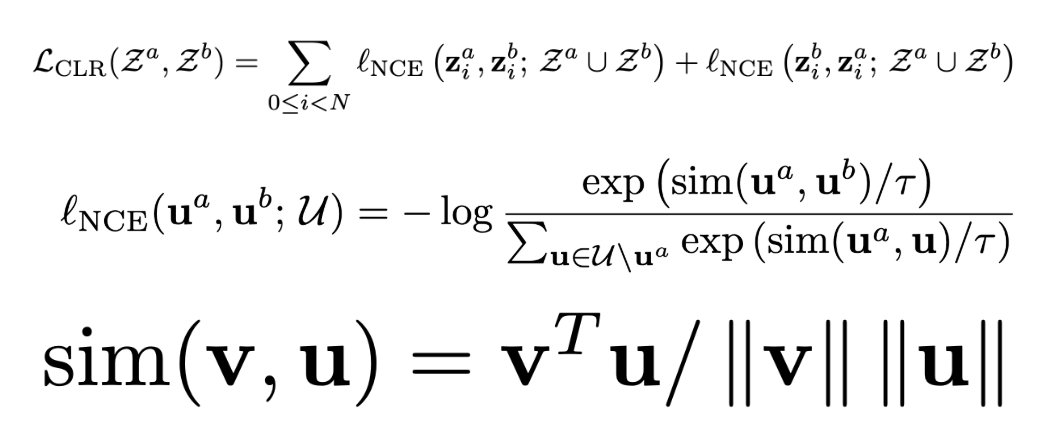

In [32]:
# class ContrastiveLossSplit():#(tf.keras.losses.Loss):

#     def __init__(self, temp=0.5, name='contrastive_loss'):
#         super().__init__()
#         self.temp = temp

#     def call(self, z):
#         # z: [2N, n,n,c] (batch, n,n,c)
#         # z_a, z_b are batches of represntations, in which corresponding indices
#         # are positive pairs
#         # z is a tensor in which z_a and z_b are interleaved
#         N = tf.shape(z)[0] // 2
#         z_flatten = tf.reshape(z, [tf.shape(z)[0], -1])

#         z_norm = tf.math.l2_normalize(z_flatten, axis=-1) # (2N, d)
#         sim_mat = tf.matmul(z_norm, z_norm, transpose_b=True) # (2N, 2N)

#         sim_mat = tf.linalg.set_diag(sim_mat, tf.fill([2*N], float('-inf'))) # (2N, 2N)

#         exp_sim_mat = tf.math.exp(sim_mat / self.temp) # (2N, 2N)

#         z_a_idx = np.arange(0,2*N,2)
#         z_b_idx = np.arange(1,2*N,2)


#         sum_for_a = tf.reduce_sum(exp_sim_mat, axis = 1) #(2N,)
#         # --- Part 1: z_a as anchor, z_b as positive ---
#         pos_from_a = tf.gather(exp_sim_mat, z_b_idx, axis=1)      # (2N, N)
#         num_a = tf.gather_nd(pos_from_a, tf.stack([z_a_idx, tf.range(N)], axis=1))  # (N,)
#         loss_a = -tf.math.log(num_a / tf.gather(sum_for_a, z_a_idx))  # (N,)

#         # --- Part 2: z_b as anchor, z_a as positive ---
#         pos_from_b = tf.gather(exp_sim_mat, z_a_idx, axis=1)      # (2N, N)
#         num_b = tf.gather_nd(pos_from_b, tf.stack([z_b_idx, tf.range(N)], axis=1))  # (N,)
#         loss_b = -tf.math.log(num_b / tf.gather(sum_for_a, z_b_idx))  # (N,)

#         return tf.reduce_mean(tf.concat([loss_a, loss_b], axis=0))


##Combined Contrastive Loss





In [33]:
# class CombinedLatentLoss(tf.keras.losses.Loss):
#   def __init__(self, pop_var=False, alpha=0.5):
#     super().__init__(name="combined_latent_loss")
#     self.contrastive = ContrastiveLossCosine()
#     self.compactness = CompactnessLossMap(pop_var=pop_var)
#     self.alpha = alpha

#   def call(self, y_true, y_pred):
#     loss_contrastive = self.contrastive(y_true, y_pred)
#     loss_compactness = self.compactness(y_true, y_pred)
#     # tf.print(f"loss_contrastive {loss_contrastive}")
#     # tf.print(f"loss_compactness {loss_compactness}")
#     #TODO: print losses values to tune alpha
#     return self.alpha * loss_contrastive + (1-self.alpha) * loss_compactness

class CombinedLatentLoss(tf.keras.losses.Loss):
  def __init__(self, losses):
    super().__init__(name="combined_latent_loss")
    self.losses_dict = losses

  def call(self, y_true, y_pred):
    # loss_contrastive = self.contrastive(y_true, y_pred)
    # loss_compactness = self.compactness(y_true, y_pred)
    loss = 0
    for loss_dict in self.losses_dict.values():
      curr_loss = loss_dict["loss_fn"](y_true, y_pred)
      # tf.print(f"curr_loss {curr_loss}")
      loss += loss_dict["weight"] * curr_loss
    # tf.print(f"loss {loss}")
    return loss

latent_losses_cosine = {
    "contrastive_cosine": {
        "loss_fn": ContrastiveLossCosine(),
        "weight": 0.5,
    },
    "compactness": {
        "loss_fn": CompactnessLossMap(pop_var=False),
        "weight": 0.5,
    },
}


latent_losses_all = {
    "contrastive_cosine": {
        "loss_fn": ContrastiveLossCosine(),
        "weight": 1./3.,
    },
    "contrastive_euclidean": {
        "loss_fn": ContrastiveLoss(),
        "weight": 1./3.,
    },
    "compactness": {
        "loss_fn": CompactnessLossMap(pop_var=False),
        "weight": 1./3.,
    }
}

##Test

In [34]:
embeds = np.array([
    [5.,0.,0.],
    [1.5,0.,0.],
    [-1.,0.,0.],
    [1.1,0.,0.],
    [-1.2,1.,0.],
], dtype=np.float32)
ls = np.array([[1,0],[1,0],[0,1],[1,0],[0,1]])
print(f"l.shape: {ls.shape}, embeds.shape: {embeds.shape}")

lc_vc = ContrastiveCosineLossVectorized()
lc_vc_loss = lc_vc(ls, embeds)
print(f"! ContrastiveCosineLossVectorized loss {lc_vc_loss}\n")

# lc_v2 = ContrastiveCosineLossVer2()
# lc_v2_loss = lc_v2(ls, embeds)
# print(f"ContrastiveCosineLossVer2 loss {lc_v2_loss}\n")

# lc_vc_2 = ContrastiveCosineLossVectorized_v2()
# lc_vc_2_loss = lc_vc_2(ls, embeds)
# print(f"ContrastiveCosineLossVectorized_v2 loss {lc_vc_2_loss}\n")

l_com_vc = CompactnessLossVectorized()
l_com_vc_loss = l_com_vc(ls, embeds)
print(f"! CompactnessLossVectorized loss {l_com_vc_loss}\n")

lc_c_2 = ContrastiveLossCosine()
lc_c_2_loss = lc_c_2(ls, embeds)
print(f"ContrastiveLossCosine loss {lc_c_2_loss}\n")

lc_e_2 = ContrastiveLoss()
lc_e_2_loss = lc_e_2(ls, embeds)
print(f"ContrastiveLoss (euclidean) loss {lc_e_2_loss}\n")

# l_comb_vc = CombinedLatentLoss(latent_losses_cosine)
# l_comb_vc_loss = l_comb_vc(ls, embeds)
# print(f"CombinedLatentLoss loss {l_comb_vc_loss}")

# l_comb_vc = CombinedLatentLoss(latent_losses_all)
# l_comb_vc_loss = l_comb_vc(ls, embeds)
# print(f"CombinedLatentLoss all loss {l_comb_vc_loss}")


l_comb_vc = CombinedLatentLoss(latent_losses_cosine)
l_comb_vc_loss = l_comb_vc(ls, embeds)
print(f"CombinedLatentLoss loss {l_comb_vc_loss}")


l.shape: (5, 2), embeds.shape: (5, 3)
! ContrastiveCosineLossVectorized loss 0.056818269193172455

! CompactnessLossVectorized loss 0.8538888692855835

ContrastiveLossCosine loss 0.05794467031955719

ContrastiveLoss (euclidean) loss 7.164999961853027

CombinedLatentLoss loss 0.45591676235198975


In [35]:
# from tqdm.notebook import tqdm
# cnn_contrast_model = build_CNN_model(input_shape=input_shape, output_shape=num_classes, n_conv=4)
# cnn_contrast_model = adapt_to_latent_model(cnn_contrast_model, CombinedLatentLoss(latent_losses_cosine))

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


# history = cnn_contrast_model.fit(ds_train_aug_contrast, epochs=2, validation_data=ds_test_aug_contrast, callbacks=[early_stopping])# verbose=0


# # # y_preds = []
# # # embeds = []
# # # losses = []
# # # for x, (y_true, _) in tqdm(ds_test_aug_contrast):
# # #   y_pred, curr_embeds = cnn_model.predict(x, verbose=0)
# # #   l_comb_vc_loss = l_comb_vc(y_true, curr_embeds)
# # #   y_preds.append(y_pred)
# # #   embeds.append(curr_embeds)
# # #   losses.append(l_comb_vc_loss)
# # # y_preds = np.concatenate(y_preds)
# # # embeds = np.concatenate(embeds)
# # # losses = np.array(losses)

#model definition

##Pre-trained

In [36]:
from tensorflow.keras.applications import InceptionV3

In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import leaky_relu
from tensorflow.keras.callbacks import EarlyStopping


def dense_block(x, units, activation="leaky_relu", bn=True, dropout=True):
  if activation == "leaky_relu":
    x = Dense(units, activation=leaky_relu)(x)
  else:
    x = Dense(units, activation=activation)(x)
  if bn:
    x = BatchNormalization()(x)
  if dropout:
    x = Dropout(0.3)(x)
  return x

def CNN_block(x, filters, kernel_size=(3, 3), bn=True, pool=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
  if bn:
    x = BatchNormalization()(x)
  x = leaky_relu(x)
  if pool:
    x = MaxPooling2D(pool_size=(2, 2))(x)
  return x

def adapt_model(pre_trained_model, pre_trained_output_layer, output_shape,
                reduction_factor = 4, n_1d_conv=0, use_batchnorm=True, use_dropout=True):
  if n_1d_conv == 0:
    x = Flatten()(pre_trained_output_layer)
  else:
    x = CNN_block(pre_trained_output_layer, filters=pre_trained_output_layer.shape[-1] // 2, kernel_size=(1,1), pool=False)
    for i in range(n_1d_conv-1):
      x = CNN_block(x, filters=x.shape[-1] // 2 , kernel_size=(1,1), pool=False)
    x = Flatten()(x)
  while x.shape[-1] > output_shape*reduction_factor:
    x = dense_block(x, x.shape[-1] // reduction_factor, bn=use_batchnorm, dropout=use_dropout)

  x = Dense(output_shape, activation="softmax", name='classification')(x)

  model = Model(pre_trained_model.input, x)
  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
  return model

def build_inception_model(input_shape=(128, 128, 3), output_shape=10, n_1d_conv=3,
                          use_batchnorm=True, use_dropout=True):
  pre_trained_inception_model = InceptionV3(input_shape=input_shape, include_top=False, weights="imagenet")

  # Adapting the model
  for layer in pre_trained_inception_model.layers:
      layer.trainable = False

  last_layer_inception_model = pre_trained_inception_model.get_layer('mixed10')
  # print('inception: last layer output shape:', last_layer_inception_model.output.shape)
  last_output_inception_model = last_layer_inception_model.output

  inception_model = adapt_model(pre_trained_inception_model, last_output_inception_model,
                                output_shape, n_1d_conv=n_1d_conv,
                                use_batchnorm=use_batchnorm, use_dropout=use_dropout)
  return inception_model

In [38]:
import tensorflow.keras.backend as K

for i in range(3):
  inception_model = build_inception_model(input_shape=input_shape, output_shape=num_classes, n_1d_conv=i)
  trainable_count = np.sum([K.count_params(w) for w in inception_model.trainable_weights])
  print(f"1x1 conv count: {i},  trainable_count: {trainable_count}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1x1 conv count: 0,  trainable_count: 1120554
1x1 conv count: 1,  trainable_count: 2380954
1x1 conv count: 2,  trainable_count: 2696490


In [39]:
build_inception_model(input_shape=input_shape, output_shape=num_classes, n_1d_conv=0).summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 52, 52,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │         96 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 50, 50,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │         96 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_287 (Conv2D) │ (None, 50, 50,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        192 │ conv2d_287[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 24, 24,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_288 (Conv2D) │ (None, 24, 24,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        240 │ conv2d_288[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_289 (Conv2D) │ (None, 22, 22,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        576 │ conv2d_289[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 22, 22,    │          0 │ batch_normalizat

 Total params: 22,924,682 (87.45 MB)

 Trainable params: 1,120,554 (4.27 MB)

 Non-trainable params: 21,804,128 (83.18 MB)

##CNN model

In [40]:

def build_CNN_model(input_shape, output_shape, n_conv=5, reduction_factor=4,
                    use_batchnorm=True, use_dropout=True):
  input = Input(shape=input_shape)

  x = CNN_block(input, filters=8)
  # while np.prod(x.shape[1:]) > output_shape*2:
  for i in range(n_conv-1):
    x = CNN_block(x, filters=x.shape[-1]*2)

  x = Flatten()(x)
  while x.shape[-1] > output_shape*reduction_factor:
    x = dense_block(x, x.shape[-1] // reduction_factor, bn=use_batchnorm, dropout=use_dropout)
  x = Dense(output_shape, activation="softmax", name='classification')(x)

  model = Model(input, x)
  model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
  return model

In [41]:
build_CNN_model(input_shape=input_shape, output_shape=num_classes, n_conv=4).summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_379 (Conv2D)             │ (None, 105, 105, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_390         │ (None, 105, 105, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyRelu)        │ (None, 105, 105, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 52, 52, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_380 (Conv2D)             │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_391         │ (None, 52, 52, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyRelu)        │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_381 (Conv2D)             │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_392         │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_5 (LeakyRelu)        │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_382 (Conv2D)             │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_393         │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_6 (LeakyRelu)        │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 576)            │     1,327,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_394         │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 144)            │        83,088 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,390 (5.51 MB)

 Trainable params: 1,442,638 (5.50 MB)

 Non-trainable params: 1,752 (6.84 KB)

##Adapt to contrastive

In [42]:
def adapt_to_latent_model(model, latent_loss, dense_index_from_end=3):
  dense_layers = [layer for layer in model.layers if isinstance(layer, Dense)]
  latent_layer = dense_layers[-dense_index_from_end]
  latent_layer_name = latent_layer.name
  print(latent_layer_name)
  latent_model = Model(inputs=model.input, outputs=[model.output, latent_layer.output], name='model_with_latent')
  latent_model.compile(
    optimizer=Adam(),
    loss={
        "classification": "categorical_crossentropy",
        latent_layer_name: latent_loss
    },
    loss_weights={
        "classification": 1.0,
        latent_layer_name: 0.1
    },
    metrics={"classification": "accuracy"}
  )
  return latent_model

In [43]:
cnn_contrast_model = build_CNN_model(input_shape=input_shape, output_shape=num_classes, n_conv=4)
cnn_contrast_model = adapt_to_latent_model(cnn_contrast_model, CombinedLatentLoss(latent_losses_all))
cnn_contrast_model.summary()

dense_15


Model: "model_with_latent"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_383 (Conv2D)             │ (None, 105, 105, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_397         │ (None, 105, 105, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_7 (LeakyRelu)        │ (None, 105, 105, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 52, 52, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_384 (Conv2D)             │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_398         │ (None, 52, 52, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_8 (LeakyRelu)        │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_385 (Conv2D)             │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_399         │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_9 (LeakyRelu)        │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_386 (Conv2D)             │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_400         │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_10 (LeakyRelu)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 576)            │     1,327,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_401         │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 144)            │        83,088 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,390 (5.51 MB)

 Trainable params: 1,442,638 (5.50 MB)

 Non-trainable params: 1,752 (6.84 KB)

In [44]:
in_model = build_inception_model(input_shape=input_shape, output_shape=num_classes, n_1d_conv=0)
in_model = adapt_to_latent_model(in_model, CombinedLatentLoss(latent_losses_all))
in_model.summary()

dense_18


Model: "model_with_latent"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_387 (Conv2D) │ (None, 52, 52,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │         96 │ conv2d_387[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_388 (Conv2D) │ (None, 50, 50,    │      9,216 │ activation_376[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │         96 │ conv2d_388[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_389 (Conv2D) │ (None, 50, 50,    │     18,432 │ activation_377[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        192 │ conv2d_389[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 24, 24,    │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_390 (Conv2D) │ (None, 24, 24,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        240 │ conv2d_390[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_391 (Conv2D) │ (None, 22, 22,    │    138,240 │ activation_379[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        576 │ conv2d_391[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 22, 22,    │          0 │ batch_normalizat

 Total params: 22,924,682 (87.45 MB)

 Trainable params: 1,120,554 (4.27 MB)

 Non-trainable params: 21,804,128 (83.18 MB)

#Training

##5fold cv

In [45]:
# from sklearn.model_selection import KFold
# from itertools import product
# from tqdm.notebook import tqdm
# from sklearn.metrics import make_scorer, accuracy_score
# from tensorflow.keras.metrics import CategoricalAccuracy


# #data_generator_train.flow(X_train_pairs, y_train_pairs, batch_size=4, shuffle=False)

# def grid_search_cv_from_ds(ds, build_model, param_grid, target_label,
#                            train_data_aug, test_data_aug,
#                            input_shape, label_shape,
#                            batch_size=32, n_splits=5):
#     best_acc = 0
#     best_params = None

#     n = ds.cardinality().numpy()
#     idxs = np.arange(n)
#     ds_indexed = ds.enumerate()

#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

#     for params in tqdm(product(*param_grid.values())):
#         param_dict = dict(zip(param_grid.keys(), params))
#         print(f"Testing params: {param_dict}")

#         epochs = param_dict.pop("epochs")

#         acc_scores = []
#         for train_idx, val_idx in kf.split(idxs):
#             # train_set = set(train_idx)
#             # val_set = set(val_idx)

#             ds_train_cv = ds_indexed.filter(lambda i, _: tf.reduce_any(tf.equal(i, train_idx)))
#             ds_val_cv = ds_indexed.filter(lambda i, _: tf.reduce_any(tf.equal(i, val_idx)))

#             # Drop index
#             ds_train_cv = ds_train_cv.map(lambda i, data: data)
#             ds_val_cv = ds_val_cv.map(lambda i, data: data)

#             #preprocess
#             ds_train_cv_aug = ds_train_cv.map(lambda x: (train_data_aug(x['image']), x[target_label]))
#             ds_val_cv_aug = ds_val_cv.map(lambda x: (test_data_aug(x['image']), x[target_label]))

#             ds_train_cv_aug = ds_train_cv_aug.batch(batch_size=batch_size).prefetch(100)#(tf.data.AUTOTUNE)
#             ds_val_cv_aug = ds_val_cv_aug.batch(batch_size=batch_size).prefetch(100)#(tf.data.AUTOTUNE)

#             with tf.device('/GPU:0'):
#               model = build_model(input_shape, label_shape, **param_dict)
#               model.fit(ds_train_cv_aug, epochs=epochs,
#                         validation_data=ds_val_cv_aug,# verbose=0
#               )
#               loss, acc = model.evaluate(ds_val_cv_aug, verbose=0)
#             acc_scores.append(acc)

#         avg_acc = np.mean(acc_scores)
#         print(f"Avg ACC: {avg_acc}\n")

#         if avg_acc > best_acc:
#             best_acc = avg_acc
#             best_params = {**param_dict,
#                            "epochs": epochs}


#     print(f"Best params: {best_params} with ACC: {best_acc}")
#     return best_params, best_acc

In [46]:
# cnn_param_grid = {
#     'n_conv': [4],
#     'reduction_factor': [4],
#     'use_dropout': [True], #, False],
#     'use_batchnorm': [True], #, False],
#     'epochs': [10],
# }


# best_params, best_acc = grid_search_cv_from_ds(
#     ds_train, build_model=build_CNN_model, param_grid=cnn_param_grid,
#     target_label=target_label,
#     train_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=True),
#     test_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=False),
#     input_shape=input_shape, label_shape=num_classes)

In [47]:
# inception_param_grid = {
#     'n_1d_conv': [0], #,1]
#     'use_dropout': [True], #, False],
#     'use_batchnorm': [True], #, False],
#     'epochs': [5],#, 10]#, 30, 50],
# }

# best_params, best_acc = grid_search_cv_from_ds(
#     ds_train, build_model=build_inception_model, param_grid=inception_param_grid,
#     target_label=target_label,
#     train_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=True),
#     test_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=False),
#     input_shape=input_shape, label_shape=num_classes)

##train full set


In [48]:
def prepare_ds(train_ds, test_ds, target_label, contrast_loss=False):
  train_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=True)
  test_data_aug=get_preprocessing_pipeline(resize_shape=None, is_training=False)

  if contrast_loss:
    ds_train_aug = train_ds.map(lambda x: (train_data_aug(x['image']), (x[target_label],x[target_label])))
    ds_test_aug = test_ds.map(lambda x: (test_data_aug(x['image']), (x[target_label],x[target_label])))
  else:
    ds_train_aug = train_ds.map(lambda x: (train_data_aug(x['image']), x[target_label]))
    ds_test_aug = test_ds.map(lambda x: (test_data_aug(x['image']), x[target_label]))

  ds_train_aug = ds_train_aug.batch(batch_size=32).prefetch(100)
  ds_test_aug = ds_test_aug.batch(batch_size=32).prefetch(100)
  return ds_train_aug, ds_test_aug

def train_model(train_ds, test_ds, param_grid, build_model, contrast_loss=None):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

  epochs = param_grid.pop("epochs")
  # tf.config.optimizer.set_experimental_options({'disable_jit': True})

  with tf.device('/GPU:0'):
    model = build_model(input_shape=input_shape, output_shape=num_classes, **param_grid)
    if contrast_loss:
      model = adapt_to_latent_model(model, contrast_loss)
    # tf.profiler.experimental.start(log_dir)
    history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, callbacks=[early_stopping])# verbose=0
    # tf.profiler.experimental.stop()
  return model, history

In [49]:
inception_param_grid = {
  'use_dropout': True,
  'use_batchnorm': True,
  'epochs': 10,
  'n_1d_conv': 0
}
cnn_param_grid = {
  'use_dropout': True,
  'use_batchnorm': True,
  'epochs': 30,
  'n_conv': 4,
  'reduction_factor': 4
}

ds_train_aug, ds_test_aug = prepare_ds(train_ds=ds_train_split, test_ds=ds_test_split,
                                       target_label=target_label, contrast_loss=False)

cnn_model, cnn_history = train_model(train_ds=ds_train_aug, test_ds=ds_test_aug,
                                 param_grid=cnn_param_grid,
                                 build_model=build_CNN_model, contrast_loss=None)

Epoch 1/30
    129/Unknown 61s 404ms/step - accuracy: 0.3287 - loss: 2.1614

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 466ms/step - accuracy: 0.3292 - loss: 2.1591 - val_accuracy: 0.0862 - val_loss: 7.9332
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 623ms/step - accuracy: 0.5193 - loss: 1.4035 - val_accuracy: 0.2154 - val_loss: 3.3955
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 628ms/step - accuracy: 0.5825 - loss: 1.2211 - val_accuracy: 0.6412 - val_loss: 1.0828
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 440ms/step - accuracy: 0.6075 - loss: 1.1190 - val_accuracy: 0.6888 - val_loss: 0.9905
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.6442 - loss: 0.9973 - val_accuracy: 0.7205 - val_loss: 0.8119
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 642ms/step - accuracy: 0.6640 - loss: 0.9754 - val_accuracy: 0.5652 - val_loss: 1.3474
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 141s 635ms/step - accuracy: 0.6853 - loss: 0.9071 - val_accuracy: 0.6417 - val_loss: 1.1326
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step - accuracy: 0.7080 - loss: 0.8644 - v

In [50]:
# %tensorboard --logdir=./logs

In [51]:
cnn_param_grid = {
  'use_dropout': True,
  'use_batchnorm': True,
  'epochs': 30,
  'n_conv': 4,
  'reduction_factor': 4
}

ds_train_aug_contrast, ds_test_aug_contrast = prepare_ds(train_ds=ds_train_split, test_ds=ds_test_split,
                                       target_label=target_label, contrast_loss=True)
cnn_contrast_model, cnn_contrast_history = train_model(train_ds=ds_train_aug_contrast, test_ds=ds_test_aug_contrast,
                                 param_grid=cnn_param_grid,
                                 build_model=build_CNN_model,
                                 contrast_loss=CombinedLatentLoss(latent_losses_cosine))
                                #  contrast_loss=CombinedLatentLoss(latent_losses_cosine))

dense_24
Epoch 1/30


Instructions for updating:
Use fn_output_signature instead


129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 546ms/step - classification_accuracy: 0.3467 - classification_loss: 2.0583 - dense_24_loss: 1.0641 - loss: 2.1649 - val_classification_accuracy: 0.0930 - val_classification_loss: 5.7458 - val_dense_24_loss: 0.2728 - val_loss: 5.8654
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 449ms/step - classification_accuracy: 0.5240 - classification_loss: 1.4220 - dense_24_loss: 1.1332 - loss: 1.5354 - val_classification_accuracy: 0.2222 - val_classification_loss: 5.1487 - val_dense_24_loss: 0.4837 - val_loss: 5.2749
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 625ms/step - classification_accuracy: 0.5798 - classification_loss: 1.2100 - dense_24_loss: 1.1084 - loss: 1.3209 - val_classification_accuracy: 0.5703 - val_classification_loss: 1.3179 - val_dense_24_loss: 0.8389 - val_loss: 1.4303
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 439ms/step - classification_accuracy: 0.6330 - classification_loss: 1.0683 - dense_24_loss: 1.0529 - loss: 1.1737 - val_classification_a

In [78]:
cnn_param_grid = {
  'use_dropout': True,
  'use_batchnorm': True,
  'epochs': 30,
  'n_conv': 4,
  'reduction_factor': 4
}

cnn_contrast_all_model, cnn_contrast_all_history = train_model(train_ds=ds_train_aug_contrast, test_ds=ds_test_aug_contrast,
                                 param_grid=cnn_param_grid,
                                 build_model=build_CNN_model,
                                 contrast_loss=CombinedLatentLoss(latent_losses_all))

TypeError: bad operand type for unary -: 'CombinedLatentLoss'

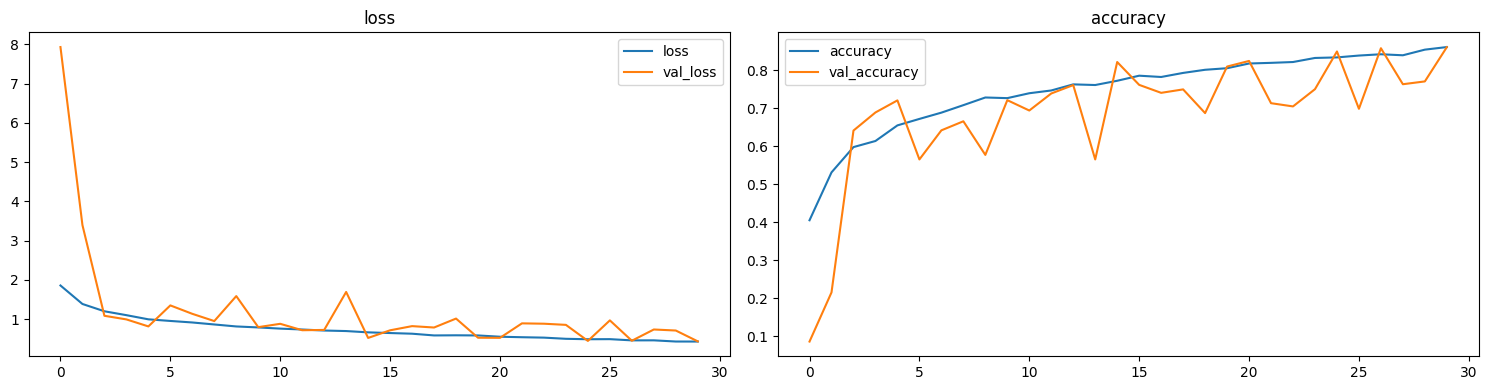

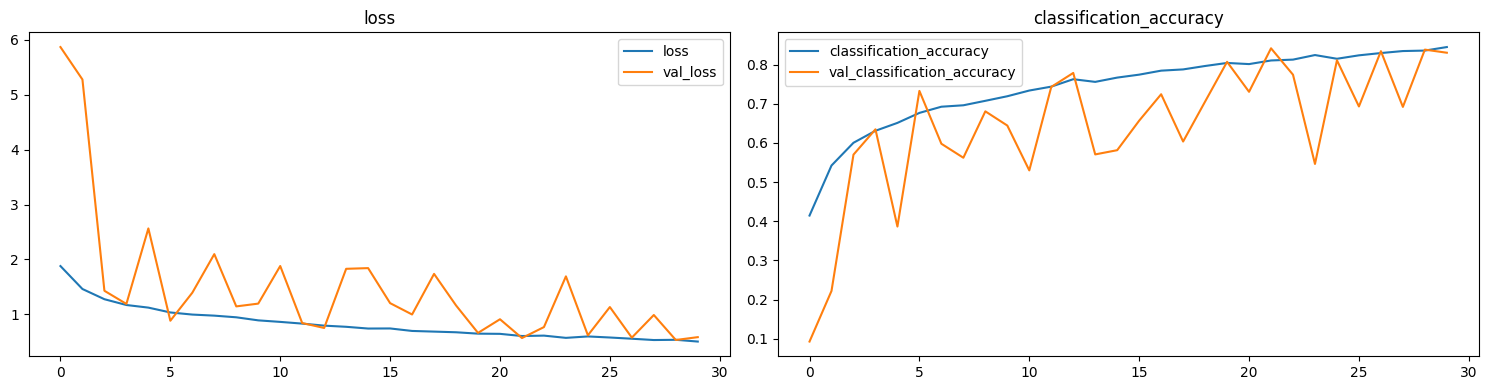

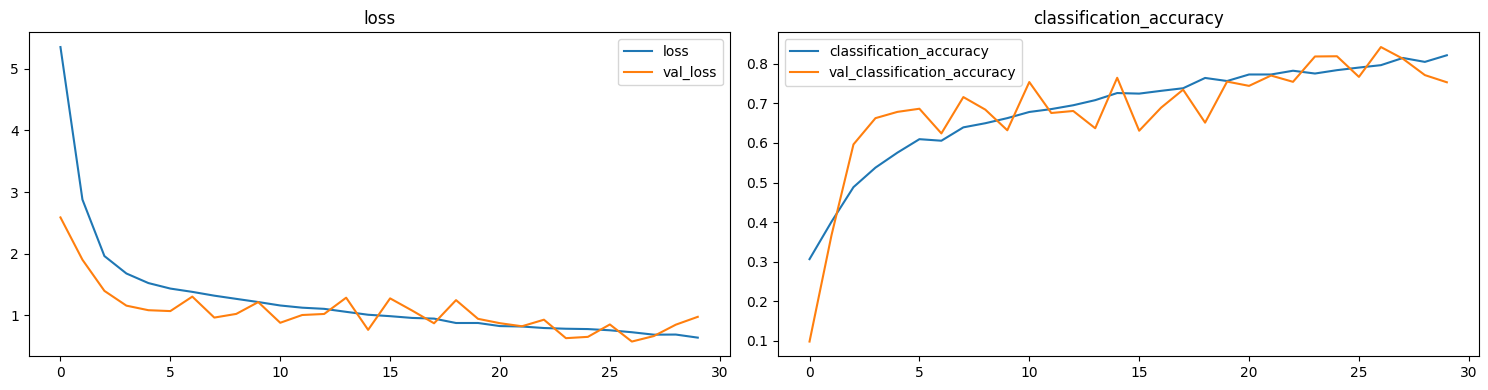

In [79]:
def plot_loss(history, metrics=("loss", "accuracy"), title="History Metrics"):
  fig, axes = plt.subplots(1,2, figsize=(15,2*2))
  for j, metric in enumerate(metrics):
    axes[j].plot(history.history[metric], label=metric)
    axes[j].plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    axes[j].set_title(f"{metric}")
    axes[j].legend()
  plt.tight_layout()
  plt.show()
plot_loss(cnn_history, title="History Metrics CNN Classification")
plot_loss(cnn_contrast_history, title="History Metrics CNN Classification & Contrastive (cosine+compact)", metrics=("loss", "classification_accuracy"))
plot_loss(cnn_contrast_all_history, title="History Metrics CNN Classification & Contrastive (cosine+compact+euclidean)", metrics=("loss", "classification_accuracy"))

#Evaluating

In [80]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def predict_ds(model, ds, is_contrast=False):
  y_true = []
  y_pred = []
  for images, labels in ds:
    probs = model.predict(images, verbose=0)
    if is_contrast:
      labels = labels[0]
      probs = probs[0]
    y_true.append(labels)
    y_pred.append(probs)

  y_true = np.vstack(y_true)
  y_pred = np.vstack(y_pred)

  # Convert to class indices
  y_true_cls = np.argmax(y_true, axis=1)
  y_pred_cls = np.argmax(y_pred, axis=1)

  predicts_df = pd.DataFrame({"y_true_cls": y_true_cls.tolist(), "y_pred_cls": y_pred_cls.tolist(), "y_true": y_true.tolist(), "y_pred": y_pred.tolist()})
  return predicts_df

def evaluate_metrics(df, labels_names):
    acc = accuracy_score(df["y_true_cls"], df["y_pred_cls"])
    print(f"Accuracy: {acc}")
    auc = roc_auc_score(np.array(df["y_true"].to_list()), np.array(df["y_pred"].to_list()), multi_class='ovr')  # Use multi_class='ovr' for softmax
    print(f"AUC: {auc:.4f}")

    print(classification_report(df["y_true_cls"], df["y_pred_cls"]))

    cnf_mat = confusion_matrix(df["y_true_cls"], df["y_pred_cls"])
    ConfusionMatrixDisplay(cnf_mat, display_labels=labels_names).plot(values_format='d')
    plt.xticks(rotation=90)
    plt.show()

def evaluate_accuracy(y, y_hat):
    acc = accuracy_score(y, y_hat)
    return acc

# probs = model.predict(ds_test_aug, verbose=0)

In [81]:
cnn_predicts_train_df = predict_ds(cnn_model, ds_train_aug)
cnn_predicts_test_df = predict_ds(cnn_model, ds_test_aug)

cnn_contrast_predicts_train_df = predict_ds(cnn_contrast_model, ds_train_aug_contrast, is_contrast=True)
cnn_contrast_predicts_test_df = predict_ds(cnn_contrast_model, ds_test_aug_contrast, is_contrast=True)

#y_true should be the same
cnn_contrast_all_predicts_train_df = predict_ds(cnn_contrast_all_model, ds_train_aug_contrast, is_contrast=True)
cnn_contrast_all_predicts_test_df = predict_ds(cnn_contrast_all_model, ds_test_aug_contrast, is_contrast=True)

In [82]:
print(f"Train accuracy: {cnn_history.history['accuracy'][-1]:.4f}")
print(f"Test accuracy: {cnn_history.history['val_accuracy'][-1]:.4f}")

print(f"Contrast Train accuracy: {cnn_contrast_history.history['classification_accuracy'][-1]:.4f}")
print(f"Contrast Test accuracy: {cnn_contrast_history.history['val_classification_accuracy'][-1]:.4f}")

print(f"Contrast All Train accuracy: {cnn_contrast_all_history.history['classification_accuracy'][-1]:.4f}")
print(f"Contrast All Test accuracy: {cnn_contrast_all_history.history['val_classification_accuracy'][-1]:.4f}")

Train accuracy: 0.8608
Test accuracy: 0.8605
Contrast Train accuracy: 0.8450
Contrast Test accuracy: 0.8305
Contrast All Train accuracy: 0.8217
Contrast All Test accuracy: 0.7534


cnn train metrics


Accuracy: 0.8753644314868805
AUC: 0.9913
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       368
           1       0.80      0.94      0.86       485
           2       0.75      0.81      0.78       450
           3       0.96      0.59      0.73       317
           4       0.82      0.96      0.89       361
           5       1.00      0.96      0.98       597
           6       0.87      0.55      0.68       340
           7       0.92      0.95      0.93       667
           8       0.75      0.95      0.84       309
           9       0.91      0.87      0.89       222

    accuracy                           0.88      4116
   macro avg       0.88      0.86      0.86      4116
weighted avg       0.88      0.88      0.87      4116



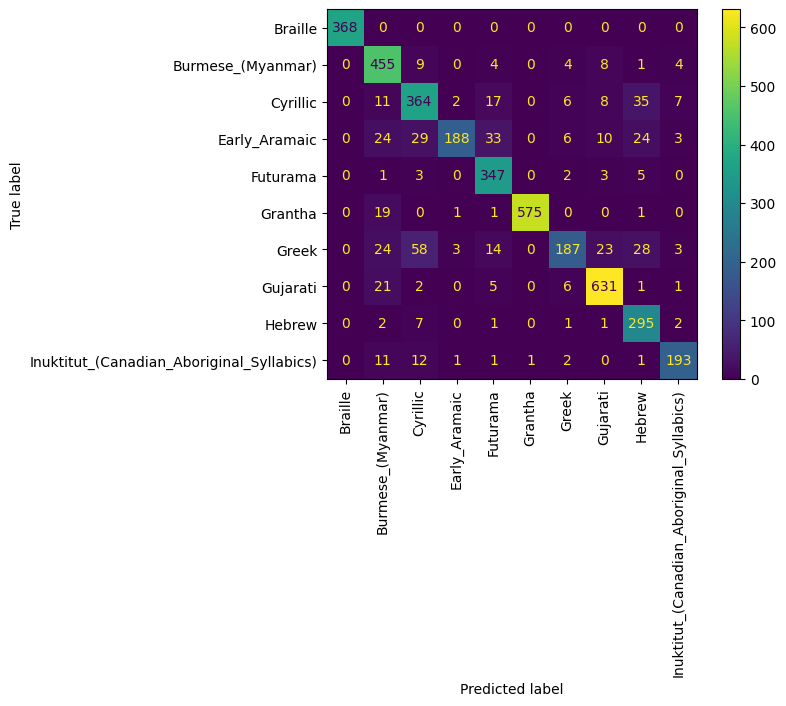

In [83]:
print(f"cnn train metrics\n\n")
evaluate_metrics(cnn_predicts_train_df, labels_names=selected_alphabets_names)

cnn test metrics


Accuracy: 0.8605442176870748
AUC: 0.9885
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.83      0.84      0.83       195
           2       0.78      0.83      0.81       210
           3       1.00      0.55      0.71       123
           4       0.71      0.97      0.82       159
           5       0.99      0.97      0.98       263
           6       0.88      0.44      0.58       140
           7       0.89      0.94      0.91       293
           8       0.73      0.97      0.83       131
           9       0.91      0.92      0.91        98

    accuracy                           0.86      1764
   macro avg       0.87      0.84      0.84      1764
weighted avg       0.87      0.86      0.85      1764



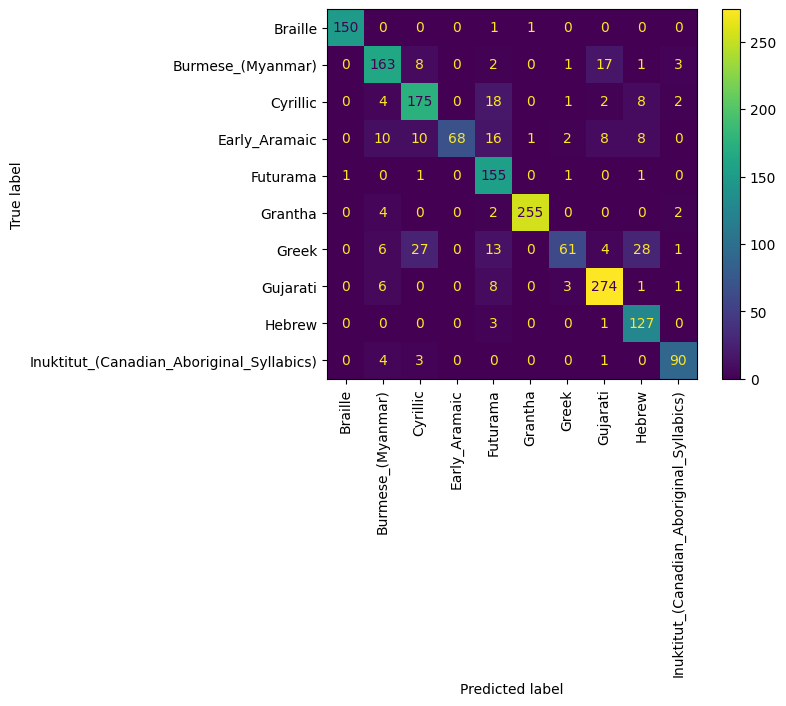

In [84]:

print(f"cnn test metrics\n\n")
evaluate_metrics(cnn_predicts_test_df, labels_names=selected_alphabets_names)

cnn contrast train metrics


Accuracy: 0.82555879494655
AUC: 0.9885
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       368
           1       0.62      0.97      0.76       485
           2       0.65      0.85      0.74       450
           3       0.85      0.83      0.84       317
           4       0.87      0.88      0.87       361
           5       0.99      0.90      0.95       597
           6       0.69      0.60      0.64       340
           7       0.98      0.76      0.86       667
           8       0.99      0.51      0.67       309
           9       0.87      0.86      0.87       222

    accuracy                           0.83      4116
   macro avg       0.85      0.82      0.82      4116
weighted avg       0.86      0.83      0.83      4116



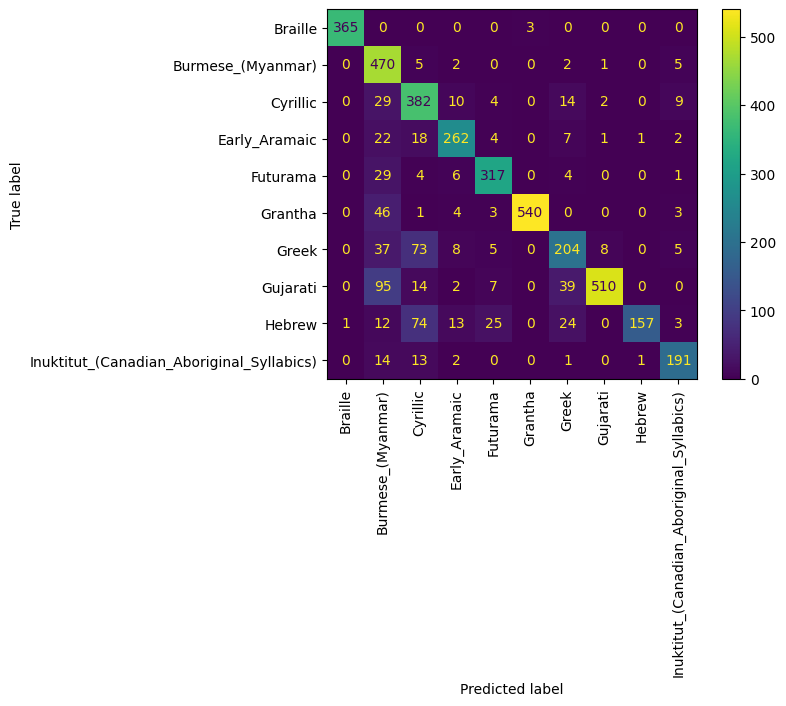

In [85]:
print(f"cnn contrast train metrics\n\n")
evaluate_metrics(cnn_contrast_predicts_train_df, labels_names=selected_alphabets_names)

cnn contrast test metrics


Accuracy: 0.8384353741496599
AUC: 0.9862
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       152
           1       0.65      0.93      0.77       195
           2       0.67      0.86      0.75       210
           3       0.80      0.72      0.76       123
           4       0.85      0.84      0.85       159
           5       0.99      0.93      0.96       263
           6       0.77      0.56      0.65       140
           7       0.97      0.87      0.92       293
           8       0.97      0.60      0.74       131
           9       0.85      0.95      0.89        98

    accuracy                           0.84      1764
   macro avg       0.85      0.82      0.83      1764
weighted avg       0.86      0.84      0.84      1764



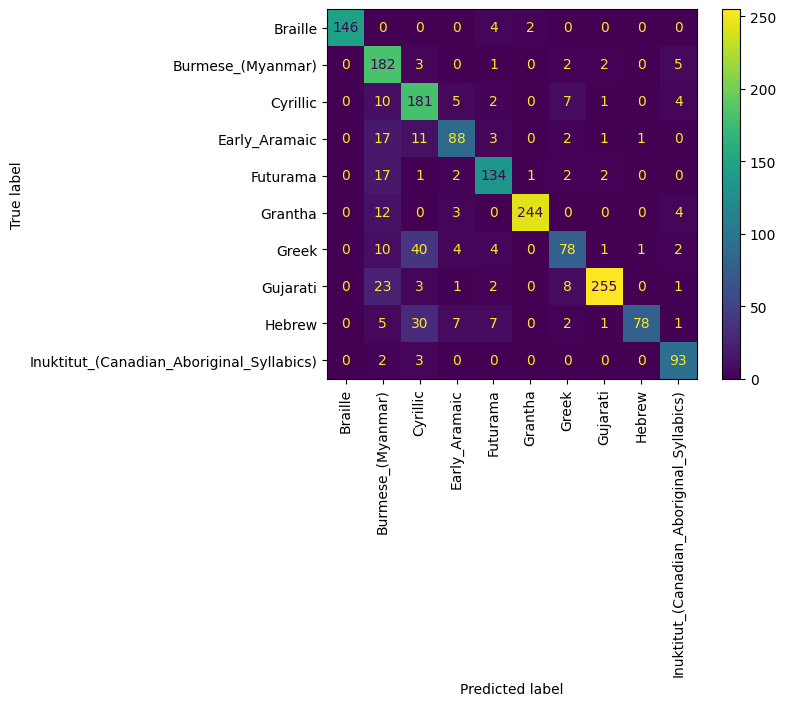

In [86]:
print(f"cnn contrast test metrics\n\n")
evaluate_metrics(cnn_contrast_predicts_test_df, labels_names=selected_alphabets_names)

cnn contrast all train metrics


Accuracy: 0.8413508260447036
AUC: 0.9839
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       368
           1       0.70      0.88      0.78       485
           2       0.85      0.72      0.78       450
           3       0.79      0.79      0.79       317
           4       0.94      0.76      0.84       361
           5       0.87      1.00      0.93       597
           6       0.79      0.45      0.57       340
           7       0.86      0.94      0.90       667
           8       0.86      0.84      0.85       309
           9       0.79      0.85      0.82       222

    accuracy                           0.84      4116
   macro avg       0.84      0.82      0.82      4116
weighted avg       0.84      0.84      0.84      4116



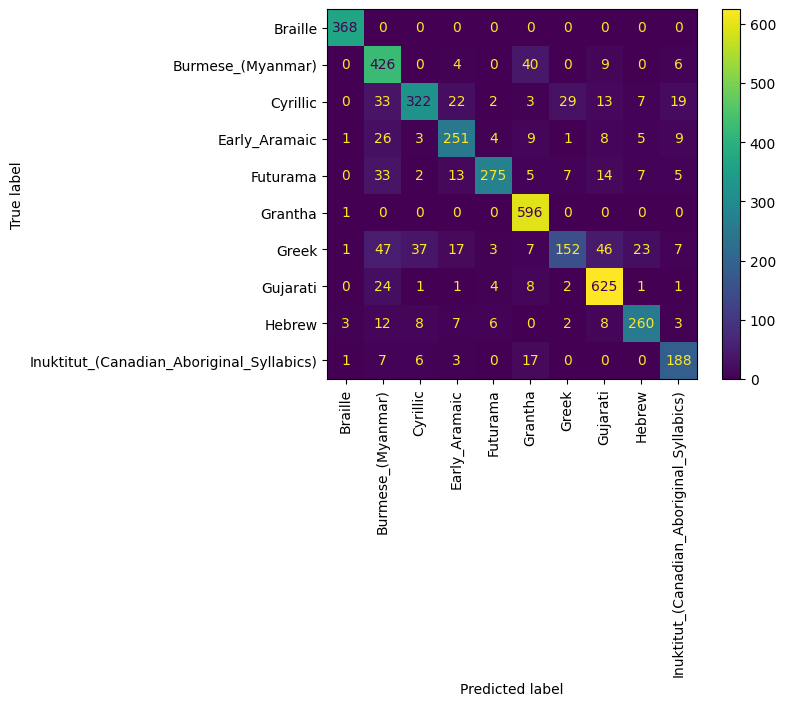

In [87]:
print(f"cnn contrast all train metrics\n\n")
evaluate_metrics(cnn_contrast_all_predicts_train_df, labels_names=selected_alphabets_names)

cnn contrast all test metrics


Accuracy: 0.8424036281179138
AUC: 0.9837
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       152
           1       0.69      0.85      0.76       195
           2       0.84      0.71      0.77       210
           3       0.79      0.77      0.78       123
           4       0.91      0.86      0.88       159
           5       0.85      1.00      0.92       263
           6       0.81      0.42      0.55       140
           7       0.88      0.94      0.91       293
           8       0.92      0.82      0.87       131
           9       0.79      0.87      0.83        98

    accuracy                           0.84      1764
   macro avg       0.84      0.82      0.82      1764
weighted avg       0.85      0.84      0.84      1764



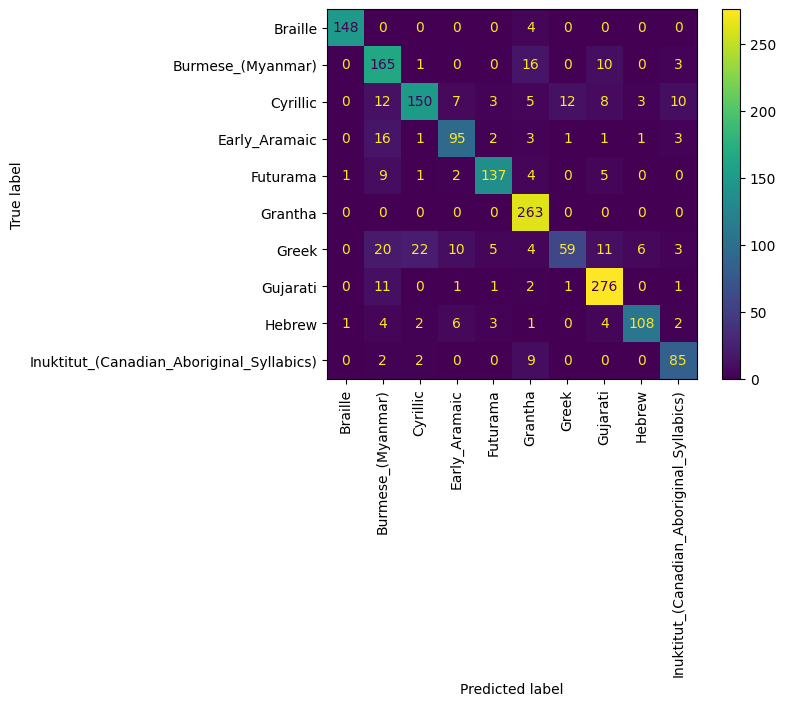

In [88]:
print(f"cnn contrast all test metrics\n\n")
evaluate_metrics(cnn_contrast_all_predicts_test_df, labels_names=selected_alphabets_names)

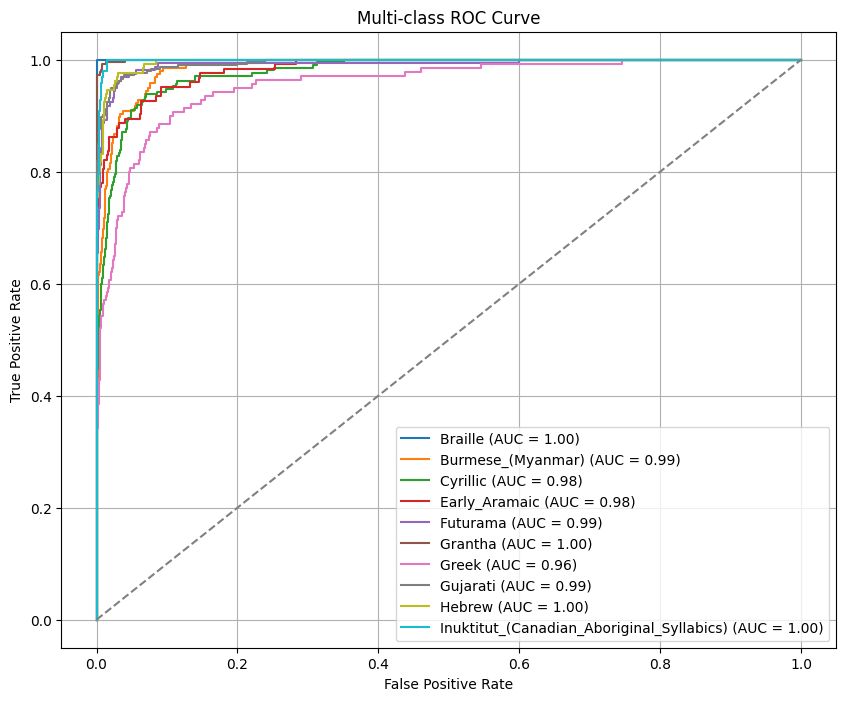

In [89]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, labels_map):
  # ROC curve for each class
  plt.figure(figsize=(10, 8))
  for i in range(len(labels_map)):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels_map[i]} (AUC = {roc_auc:.2f})")

  plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Multi-class ROC Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_roc_curve(np.array(cnn_predicts_test_df["y_true"].to_list()), np.array(cnn_predicts_test_df["y_pred"].to_list()), labels_map=selected_alphabets_names)


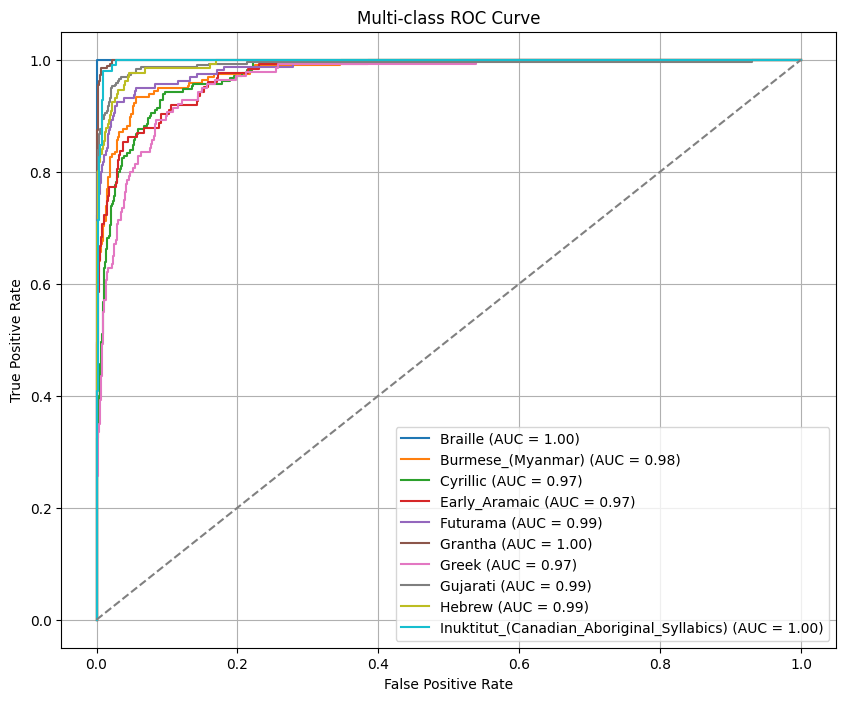

In [90]:
plot_roc_curve(np.array(cnn_contrast_predicts_test_df["y_true"].to_list()), np.array(cnn_contrast_predicts_test_df["y_pred"].to_list()), labels_map=selected_alphabets_names)

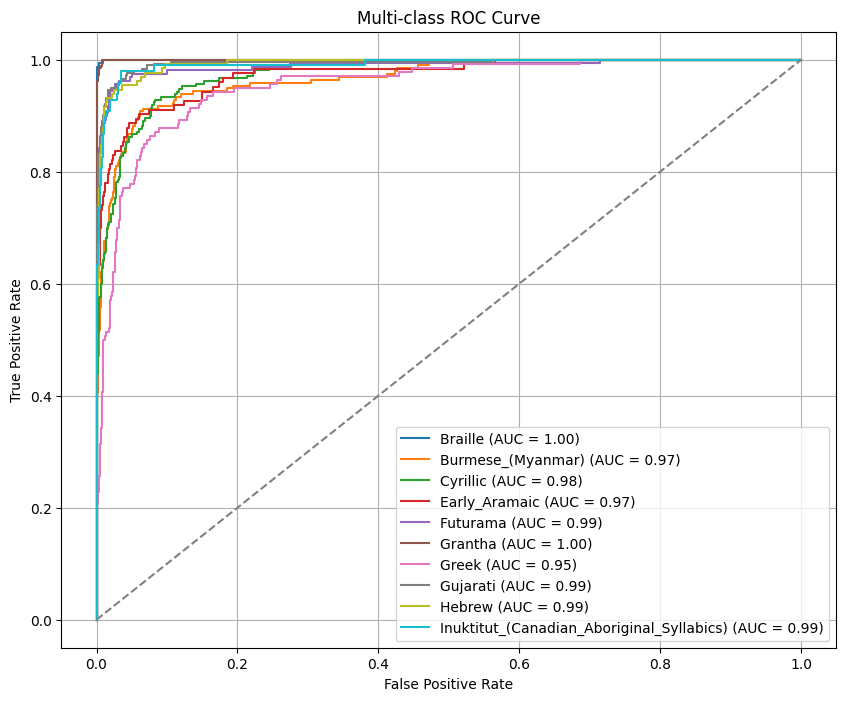

In [91]:
plot_roc_curve(np.array(cnn_contrast_all_predicts_test_df["y_true"].to_list()), np.array(cnn_contrast_all_predicts_test_df["y_pred"].to_list()), labels_map=selected_alphabets_names)

#Dimentionality reduction

##Definition

In [92]:
!pip install umap-learn


In [93]:
import umap.umap_ as umap
from sklearn.svm import SVC
import plotly.express as px

def adapt_to_latent_model(model, dense_index_from_end=3):
  dense_layers = [layer for layer in model.layers if isinstance(layer, Dense)]
  latent_layer = dense_layers[-dense_index_from_end]
  latent_layer_name = latent_layer.name
  print(latent_layer_name)

  latent_model = Model(inputs=model.input, outputs=[latent_layer.output])
  return latent_model

def get_embeds(model, ds, dense_index_from_end=3):
  embedding_model = adapt_to_latent_model(model, dense_index_from_end)

  embeddings = []
  for images, labels in ds:
    embeds = embedding_model.predict(images, verbose=0)
    embeddings.append(embeds)

  embeddings = np.vstack(embeddings)
  print(embeddings.shape)
  return embeddings


def plot_decision_boundary(X, y, model=None, title="", is_contrast=False):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    print(mesh_points.shape)
    # default model
    if model is None:
        model = SVC(kernel='rbf', gamma='scale', decision_function_shape='ovr')
        model.fit(X, y)

    Z = model.predict(mesh_points)
    if is_contrast:
      Z = Z[0]
    if Z.ndim > 1:
        Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # Plot
    cmap = plt.cm.get_cmap('tab10', 10)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=40)
    plt.title(title)
    plt.xlabel('UMAP-1')
    plt.ylabel('UMAP-2')
    plt.colorbar(scatter, ticks=range(10), label='Class')
    plt.grid(True)
    plt.show()



def plot_scatter(X, y, conf):
  plt.figure(figsize=(10, 8))
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', edgecolors='k', s=conf*40)
  plt.colorbar(ticks=range(10), label='Predicted Class')
  plt.title("UMAP Projection Colored by CNN Confidence")
  plt.xlabel('UMAP-1')
  plt.ylabel('UMAP-2')
  plt.grid(True)
  plt.show()

##Classification

In [94]:
def get_umap(train_embeds, test_embeds):
  umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
  # UMAP
  train_2d = umap_model.fit_transform(train_embeds)
  test_2d = umap_model.transform(test_embeds)
  return train_2d, test_2d

def process_dfs(predicts_train_df, predicts_test_df, train_2d, test_2d, labels_names):
  cnn_train_pred_conf = np.max(np.array(predicts_train_df['y_pred'].to_list()), axis=1)
  cnn_test_pred_conf = np.max(np.array(predicts_test_df['y_pred'].to_list()), axis=1)


  predicts_train_df["umap_1"] = train_2d[:, 0]
  predicts_train_df["umap_2"] = train_2d[:, 1]

  predicts_test_df["umap_1"] = test_2d[:, 0]
  predicts_test_df["umap_2"] = test_2d[:, 1]

  predicts_train_df["pred_conf"] = predicts_train_df["y_pred"].apply(lambda x: max(x))
  predicts_test_df["pred_conf"] = predicts_test_df["y_pred"].apply(lambda x: max(x))

  predicts_train_df["correct"] = predicts_train_df["y_true_cls"] == predicts_train_df["y_pred_cls"]
  predicts_test_df["correct"] = predicts_test_df["y_true_cls"] == predicts_test_df["y_pred_cls"]

  predicts_train_df["label"] = predicts_train_df["y_true_cls"].apply(lambda x: labels_names[x])
  predicts_test_df["label"] = predicts_test_df["y_true_cls"].apply(lambda x: labels_names[x])

  predicts_train_df["y_true_cls_str"] = predicts_train_df["y_true_cls"].astype(str)
  predicts_test_df["y_true_cls_str"] = predicts_test_df["y_true_cls"].astype(str)
  return predicts_train_df, predicts_test_df

def plot_scatter_px(df_umap, title):
  fig = px.scatter(
      df_umap,
      x='umap_1',
      y='umap_2',
      color='label',
      size='pred_conf',
      opacity=0.7,
      size_max=12,  # you can tune max marker size
      hover_data=["label", 'y_true_cls', 'pred_conf', 'correct', 'y_pred_cls'],
      title='UMAP Projection Colored by Class, Sized by Confidence',
      color_discrete_sequence=px.colors.qualitative.T10
  )

  fig.update_layout(
      width=900,
      height=650,
      # template='plotly_white',
      legend_title='Ground Truth Label'
  )

  fig.show()

# plot_decision_boundary(cnn_train_2d, cnn_predicts_train_df['y_true_cls'].to_list(), title="CNN Train Set with UMAP and Decision Boundary")
# plot_decision_boundary(cnn_test_2d, cnn_predicts_test_df['y_true_cls'].to_list(), title="CNN Test Set with UMAP and Decision Boundary")

In [95]:
cnn_train_embeds = get_embeds(cnn_model, ds_train_aug)
cnn_test_embeds = get_embeds(cnn_model, ds_test_aug)

cnn_train_2d, cnn_test_2d = get_umap(cnn_train_embeds, cnn_test_embeds)

cnn_predicts_train_df, cnn_predicts_test_df = process_dfs(cnn_predicts_train_df, cnn_predicts_test_df, cnn_train_2d, cnn_test_2d, selected_alphabets_names)


dense_21
(4116, 144)
dense_21
(1764, 144)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [96]:
plot_scatter_px(cnn_predicts_train_df, title="UMAP Projection Colored by Class, Sized by Confidence")

In [97]:
plot_scatter_px(cnn_predicts_test_df, title="UMAP Projection Colored by Class, Sized by Confidence")

##Classification & Contrastive Cosine



In [98]:
cnn_contrast_train_embeds = get_embeds(cnn_contrast_model, ds_train_aug_contrast)
cnn_contrast_test_embeds = get_embeds(cnn_contrast_model, ds_test_aug_contrast)

cnn_contrast_train_2d, cnn_contrast_test_2d = get_umap(cnn_contrast_train_embeds, cnn_contrast_test_embeds)

cnn_contrast_predicts_train_df, cnn_contrast_predicts_test_df = process_dfs(cnn_contrast_predicts_train_df, cnn_contrast_predicts_test_df, cnn_contrast_train_2d, cnn_contrast_test_2d, selected_alphabets_names)



dense_24
(4116, 144)
dense_24
(1764, 144)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [99]:
plot_scatter_px(cnn_contrast_predicts_train_df, title="UMAP Projection Colored by Class, Sized by Confidence")

In [100]:
plot_scatter_px(cnn_contrast_predicts_test_df, title="UMAP Projection Colored by Class, Sized by Confidence")
#

##Classification & Contrastive Cosine & Contrastive Euclidean

In [101]:
cnn_contrast_all_train_embeds = get_embeds(cnn_contrast_all_model, ds_train_aug_contrast)
cnn_contrast_all_test_embeds = get_embeds(cnn_contrast_all_model, ds_test_aug_contrast)

cnn_contrast_all_train_2d, cnn_contrast_all_test_2d = get_umap(cnn_contrast_all_train_embeds, cnn_contrast_all_test_embeds)

cnn_contrast_all_predicts_train_df, cnn_contrast_all_predicts_test_df = process_dfs(cnn_contrast_all_predicts_train_df, cnn_contrast_all_predicts_test_df, cnn_contrast_all_train_2d, cnn_contrast_all_test_2d, selected_alphabets_names)

dense_27
(4116, 144)
dense_27
(1764, 144)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [102]:
plot_scatter_px(cnn_contrast_all_predicts_train_df, title="UMAP Projection Colored by Class, Sized by Confidence")
#

In [103]:
plot_scatter_px(cnn_contrast_all_predicts_test_df, title="UMAP Projection Colored by Class, Sized by Confidence")
#